# Imports

In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

#for saving data
import csv
import h5py

# #custom analysis packages
# import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

# Functions

In [2]:
def parse_ome(file, channel_list=['405', '480']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata
        
    #how the pages are stored in ome
    ch1 = images[0::2] #0 for first channel : : 2 for 2 total channels
    ch2 = images[1::2] #1 for first channel : : 2 for 2 total channels
    
    return [np.array(ch1), np.array(ch2)]

In [3]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

In [4]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

In [5]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

In [6]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [7]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        print(norm_mat[mask_coords].shape)
        
        arrs_ev_temp = np.zeros_like(arr)
        # print(arr[allmask_coords].shape)
        # print(norm_mat[mask_coords].shape)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

# Import Data
Find directories and parse images

In [8]:
# 2024 ATP Calibration
srcdir24 = '../../data/atp_cal/ATP_Calibration_Dec2024/'
#extract all the ATP values
directories24=glob.glob(srcdir24+'*')
ATPconcs24 = np.sort([int(x.split('20sInterval_')[1].split('uMATP')[0]) for x in directories24])
#parse images from subdirectories
results24={}
for a, atp in enumerate(ATPconcs24):
    idx = np.where(['_'+str(atp)+'uMATP' in x for x in directories24])[0][0]    
    subDir=glob.glob(directories24[idx]+'/*.tif') # this gives a list of the numberOfPositions=three ome.tif names
    #parse each position and save with channel label too
    Pos24 = []
    for d in subDir:
        posidx = int(d.split('Pos')[1].split('.')[0])
        Pos24.append(posidx)
        theseResults=parse_ome(d) #[parse_ome(x) for x in subDir] # this is a list of length(numberOfPositions)
        results24[atp, posidx,'405']=theseResults[0]
        results24[atp, posidx, '480']=theseResults[1]
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%" , end=" ")
print('')

# 2023 ATP Calibration
srcdir23 = '../../data/atp_cal/2023-12-16_A81D_Cal/ATP_calibration_A81D_All_images_12_16_2023/'
#extract all the ATP values
directories23=glob.glob(srcdir23+'*')
ATPconcs23 = np.sort([int(x.split('/')[-1].split('uMATP')[0]) for x in directories23])
#parse images from subdirectories
results23={}
for a, atp in enumerate(ATPconcs23):
    idx = np.where([str(atp)+'uMATP' in x for x in directories23])[0][0]
    subDir = glob.glob(directories23[idx]+'/*Pos*')
    Pos23 = [int(x.split('Pos')[-1]) for x in subDir]
    #enter each position folder and identify channels
    for p, pos in enumerate(Pos23):
        subsubDir = glob.glob(subDir[p]+'/*.tif*')
        channames, chanidxs = np.unique([x.split('QUEEN')[-1].split('_')[0] for x in subsubDir], return_inverse=True)
        # save by channel type
        for c, channame in enumerate(channames):
            subsubsubDir = np.array(subsubDir)[np.where(chanidxs==c)[0]]
            results23[atp, pos, channame] = file_to_image(subsubsubDir)
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs23)))+"%" , end=" ")


100% 
100% 

# View images
(dont have to run)

In [9]:
results24[0, 0, '405'].shape

(25, 1200, 1920)

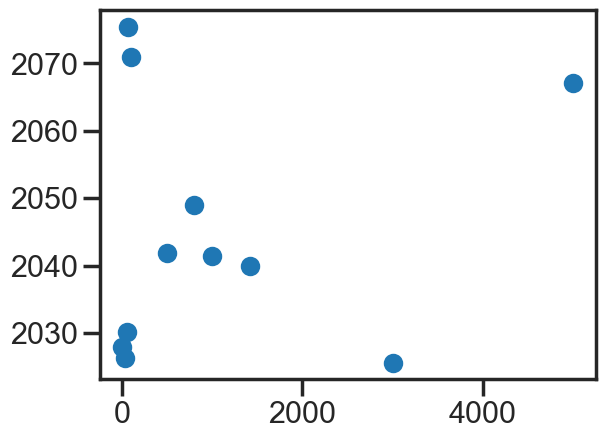

In [10]:
plt.scatter(ATPconcs24, np.average(np.array([results24[k, 0, '405'] for k in ATPconcs24 ] ), axis=(2,3))[:, 0])

In [11]:
crop = np.s_[300:900, 700:1300] #set a crop that is roughly the size and location of the aster/mango region
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

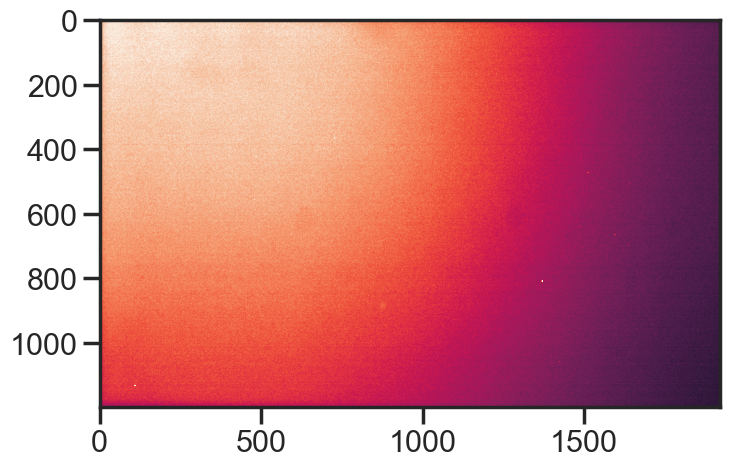

In [12]:
channel0example=results23[100, 0, '405']
channel0example.shape

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(channel0example[0,:,:], vmax=np.percentile(channel0example[0,:,:], 99))

# Crop and average

In [13]:
### Hackish extraction dun dun dun
cropAcrossTimes = np.s_[:, 300:900, 700:1300]
summaryResults={}
for atp in ATPconcs:
    thisATPresult=results[atp]
    for pos in range(len(thisATPresult)):
        for channel in range(len(thisATPresult[pos])):
            summaryResults[(atp, pos, channel)]=np.mean(thisATPresult[pos][channel][cropAcrossTimes], axis=(1,2))

NameError: name 'ATPconcs' is not defined

Plot intensity vs. time on the same y range for each channel

Text(0.5, 0, 'time')

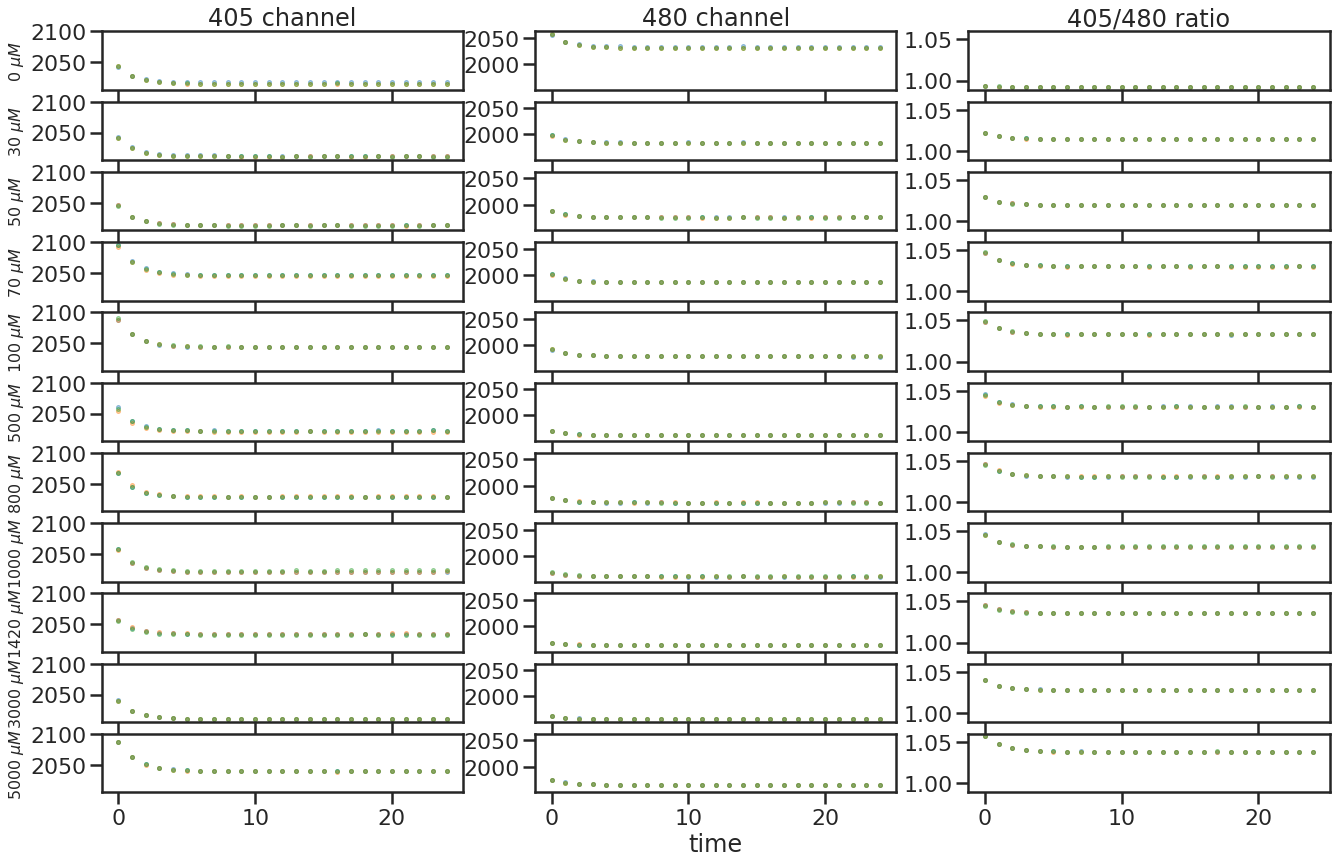

In [15]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Let the scale vary for eeach plot

Text(0.5, 0, 'time')

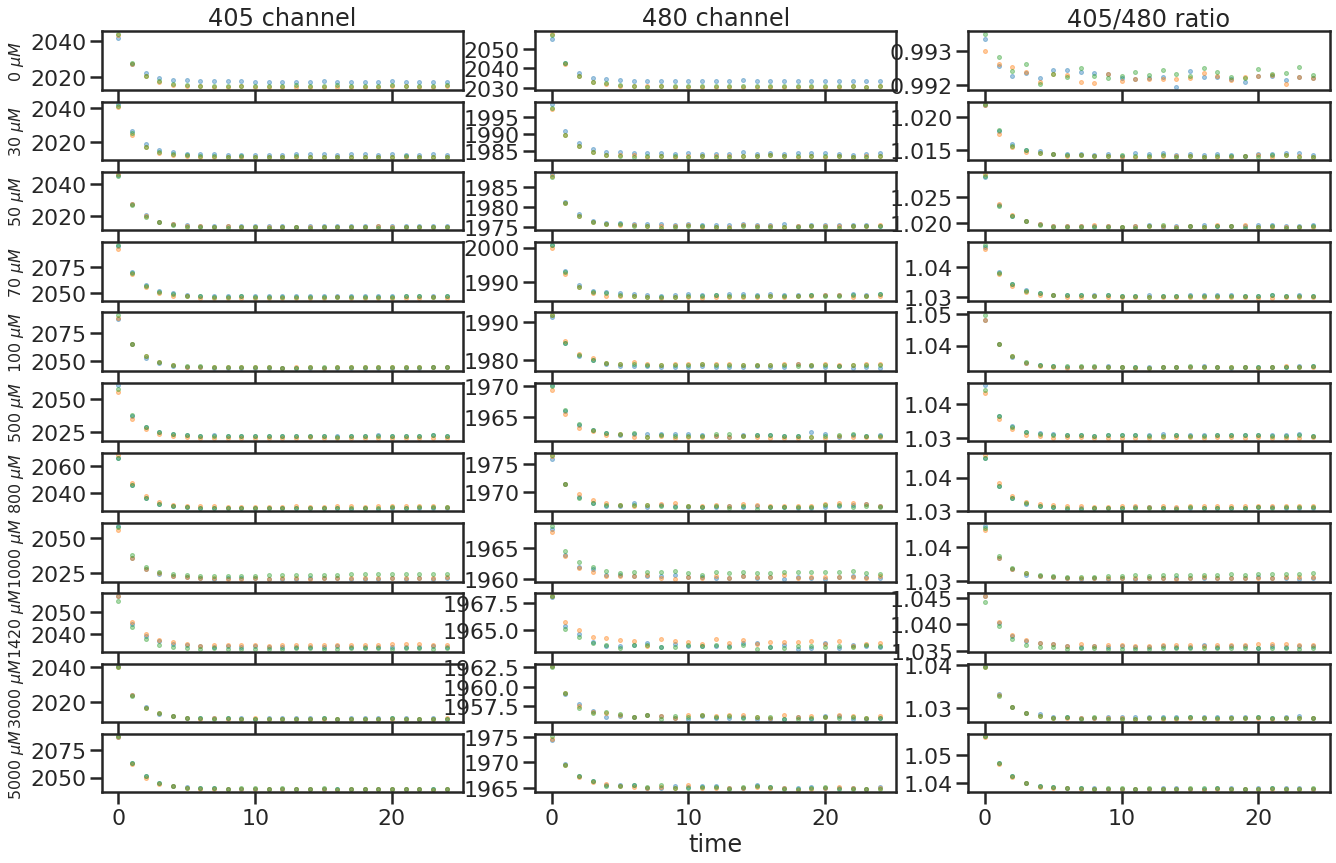

In [16]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Examine the derivative

Text(0.5, 0, 'time')

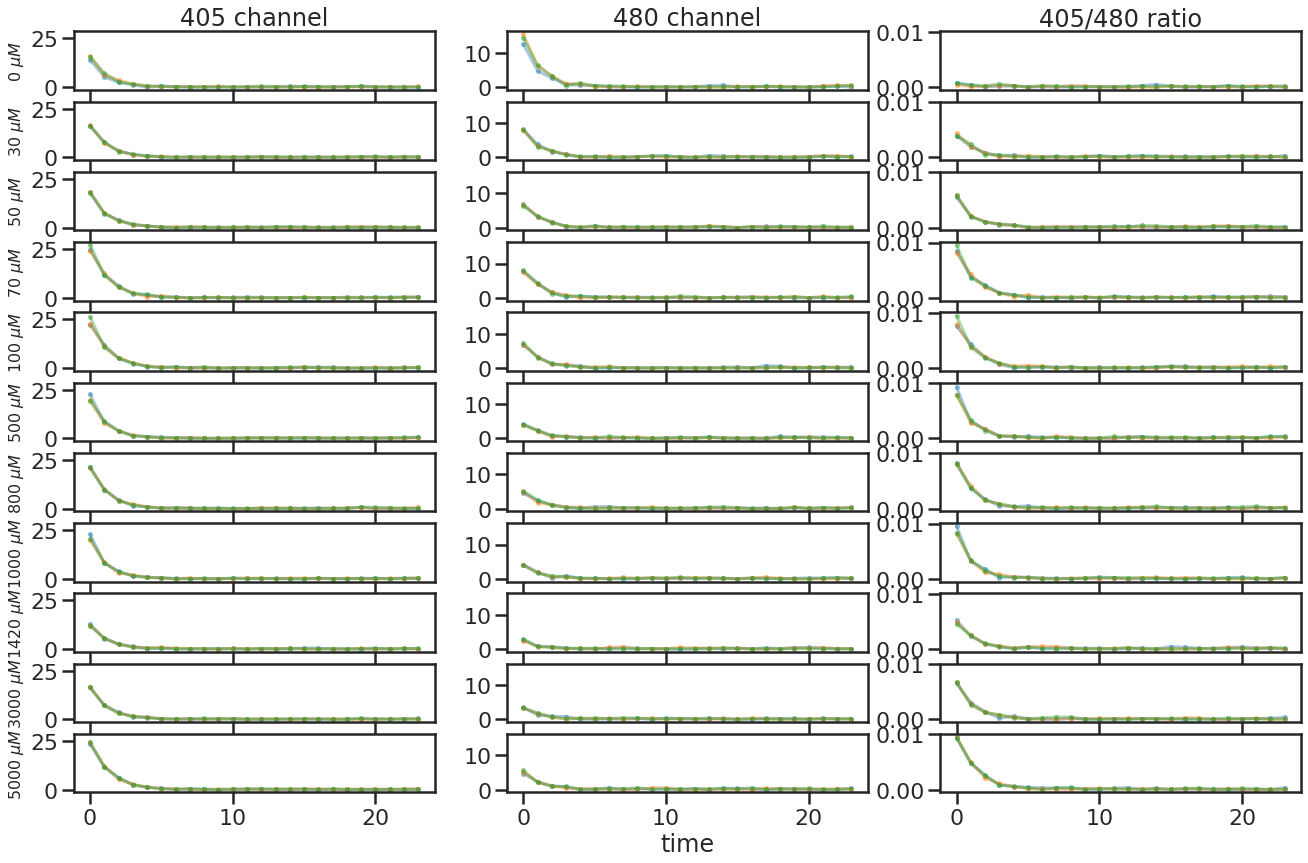

In [17]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, col)])), 'o-', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)])), 'o-', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

log scale

Text(0.5, 0, 'time')

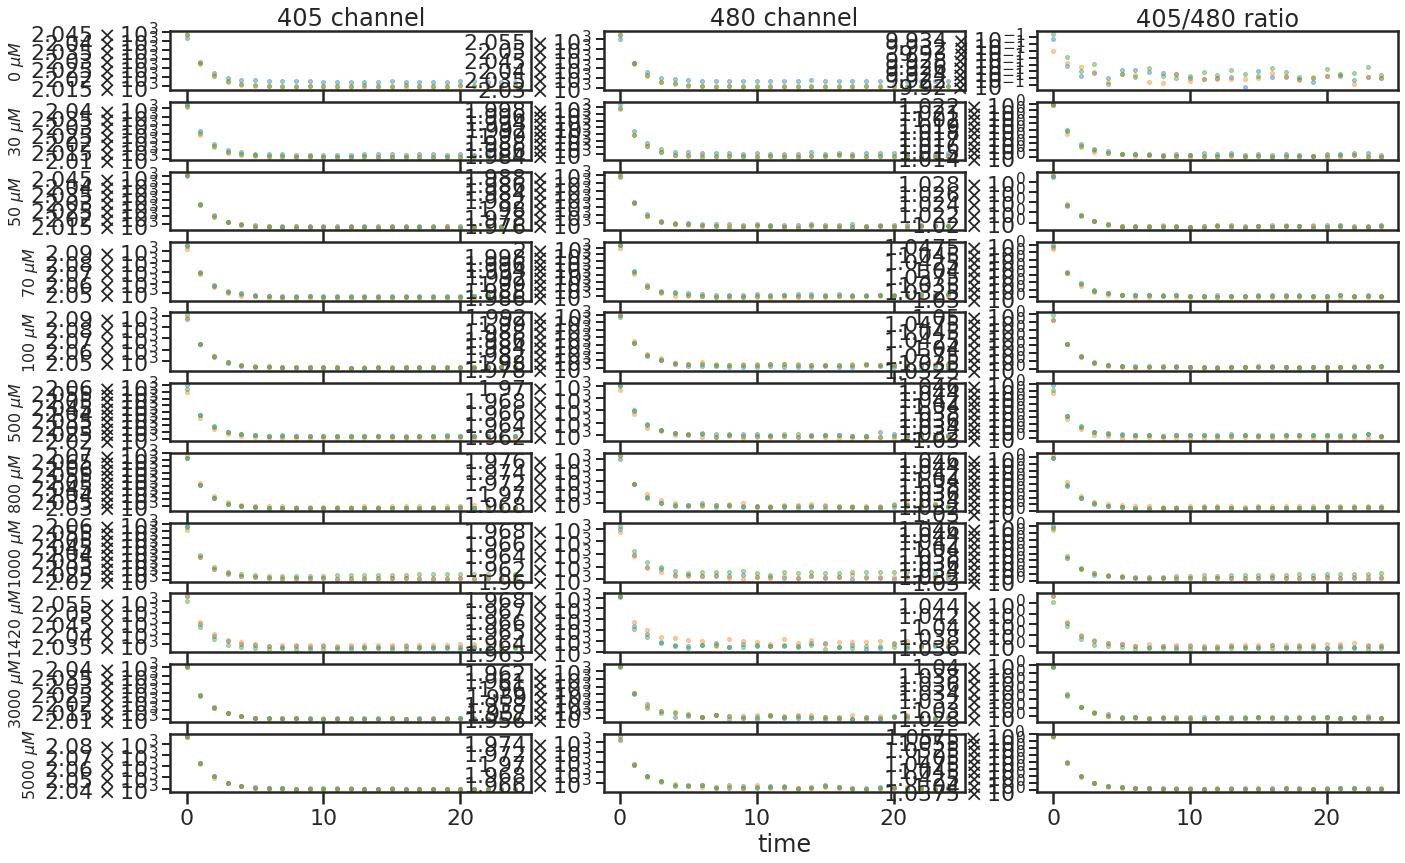

In [18]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            ax[a][col].set_yscale('log')

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

# Do it with fixing uneven illumination

doesnt acount for anomolyous bright spots

In [14]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted


def norm_unev(arr):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arr (np.array): Dark image subtracted image array.
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (np.array): image array after the evening process.
    norm_mat (np.array): array to use to normalize uneven illumination.
    """
    #norm_mats = []
    arrs_ev = []
    
    #compute the bivariate filter
    biv_filt = np.zeros_like(arr[0]) 
    biv_filt = evaluateBivPoly(arr[0, :, :])
    #norm_mats.append(norm_mat)
    #print("time after polynomial fitting", time.time());
    #scale the normalization matrix such that the average value after multiplication is the same as the bs image

    scalar = np.mean(arr[0])/np.mean(arr[0]/biv_filt)

    # Normalisation
    norm_mat = scalar/biv_filt
    # print("shape of norm mat", norm_mat.shape)
    # print("shape of arr", arr.shape)
    # print("time after normalising matrix", time.time());

    arrs_ev = np.zeros_like(arr)
    arrs_ev=arr*norm_mat; 
    #print("time after multiplying arr with norm_mat", time.time());
        
    return arrs_ev

perform uneven illum correction and then average images. For ratios, I took the mean first. If you divide and then take the mean there are NaNs from divide by zeros

Compute evened results and store the average value of images for all datasets

In [15]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

# mask = np.zeros_like(dark_avg)
# mask[crop] = 1

# crop_coords = np.where(mask==1)

# mask = np.zeros_like(results[0][0][0])
# mask[cropAcrossTimes] = 1
# allcrop_coords = np.where(mask==1)

tstart=time.time()
evenedResults24={}
for a, atp in enumerate(ATPconcs24):
    for pos in Pos24:
        for channel in ['405','480']:
            arrs = results24[atp, pos, channel]
            arrs_sub = backSubtract(arrs, dark_avg)
            arrs_even=norm_unev(np.array(arrs_sub)[cropAcrossTimes])
            # arrs_405even=norm_unev(arrs_sub[0][cropAcrossTimes])
            # arrs_480even=norm_unev(arrs_sub[1][cropAcrossTimes])
            #ratios = arrs_even[0]/arrs_even[1]

            evenedResults24[(atp, pos, channel)] = np.mean(arrs_even, axis=(1,2))
            #evenedResults24[(atp, pos, '480')] = np.mean(arrs_480even, axis=(1,2))
        evenedResults24[(atp, pos, 'ratio')] = evenedResults24[(atp, pos, '405')]/evenedResults24[(atp, pos, '480')] #np.mean(arrs_405even, axis=(1,2))/np.mean(arrs_480even, axis=(1,2)) #np.nanmean(ratios, axis=(1,2)) #mean first
            #evenedResults[(atp, pos, 'ratio')] = np.nanmean(ratios, axis=(1,2)) #divide first

        # Manual Status bar
        print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
        
print('')

tstart=time.time()
evenedResults23={}
for a, atp in enumerate(ATPconcs23):
    for pos in Pos23:
        for channel in ['405','480']:
            arrs = results23[atp, pos, channel]
            arrs_sub = backSubtract(arrs, dark_avg)
            arrs_even=norm_unev(np.array(arrs_sub)[cropAcrossTimes])
            # arrs_405even=norm_unev(arrs_sub[0][cropAcrossTimes])
            # arrs_480even=norm_unev(arrs_sub[1][cropAcrossTimes])
            #ratios = arrs_even[0]/arrs_even[1]

            evenedResults23[(atp, pos, channel)] = np.mean(arrs_even, axis=(1,2))
            #evenedResults23[(atp, pos, '480')] = np.mean(arrs_480even, axis=(1,2))
        evenedResults23[(atp, pos, 'ratio')] = evenedResults23[(atp, pos, '405')]/evenedResults23[(atp, pos, '480')] #np.mean(arrs_405even, axis=(1,2))/np.mean(arrs_480even, axis=(1,2)) #np.nanmean(ratios, axis=(1,2)) #mean first
            #evenedResults[(atp, pos, 'ratio')] = np.nanmean(ratios, axis=(1,2)) #divide first

        # Manual Status bar
        print("\r"+str(round((a+1)*100/len(ATPconcs23)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")

100%, time elapsed: 9 seconds 
100%, time elapsed: 5 seconds 

Plot how the ratios change with time

Text(0.5, 0, 'ATP Concentration (µM)')

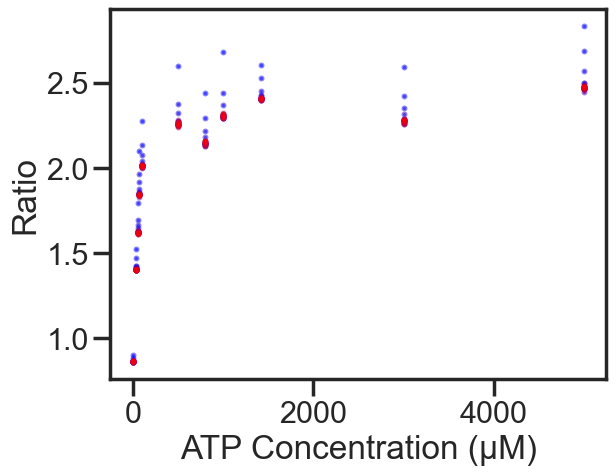

In [17]:
for t in range(25):
    plt.scatter(ATPconcs24, np.array([evenedResults24[k, 0, 'ratio'] for k in ATPconcs24 ])[:, t], alpha = 0.5, color=(t/25, 0, 1-t/25, 0.8), s=5 )
plt.ylabel('Ratio')
plt.xlabel('ATP Concentration (µM)')
#plt.scatter(ATPconcs24, np.array([evenedResults24[k, 0, 'ratio'] for k in ATPconcs24 ])[:, -1])

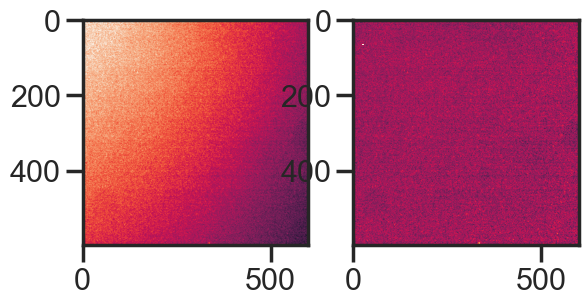

In [45]:
#visualize evening
tempatp = 0
temppos = 1
tempchannel = '405'
temptime = 0

tempims = results23[(tempatp, temppos, tempchannel)]
tempimsbs = np.array(backSubtract(tempims, dark_avg))
tempimseven = norm_unev(tempimsbs[cropAcrossTimes])

fig, ax = plt.subplots(1,2)
ax[0].imshow(tempimsbs[cropAcrossTimes][0], vmax=500)
ax[1].imshow(tempimseven[0], vmax=500)

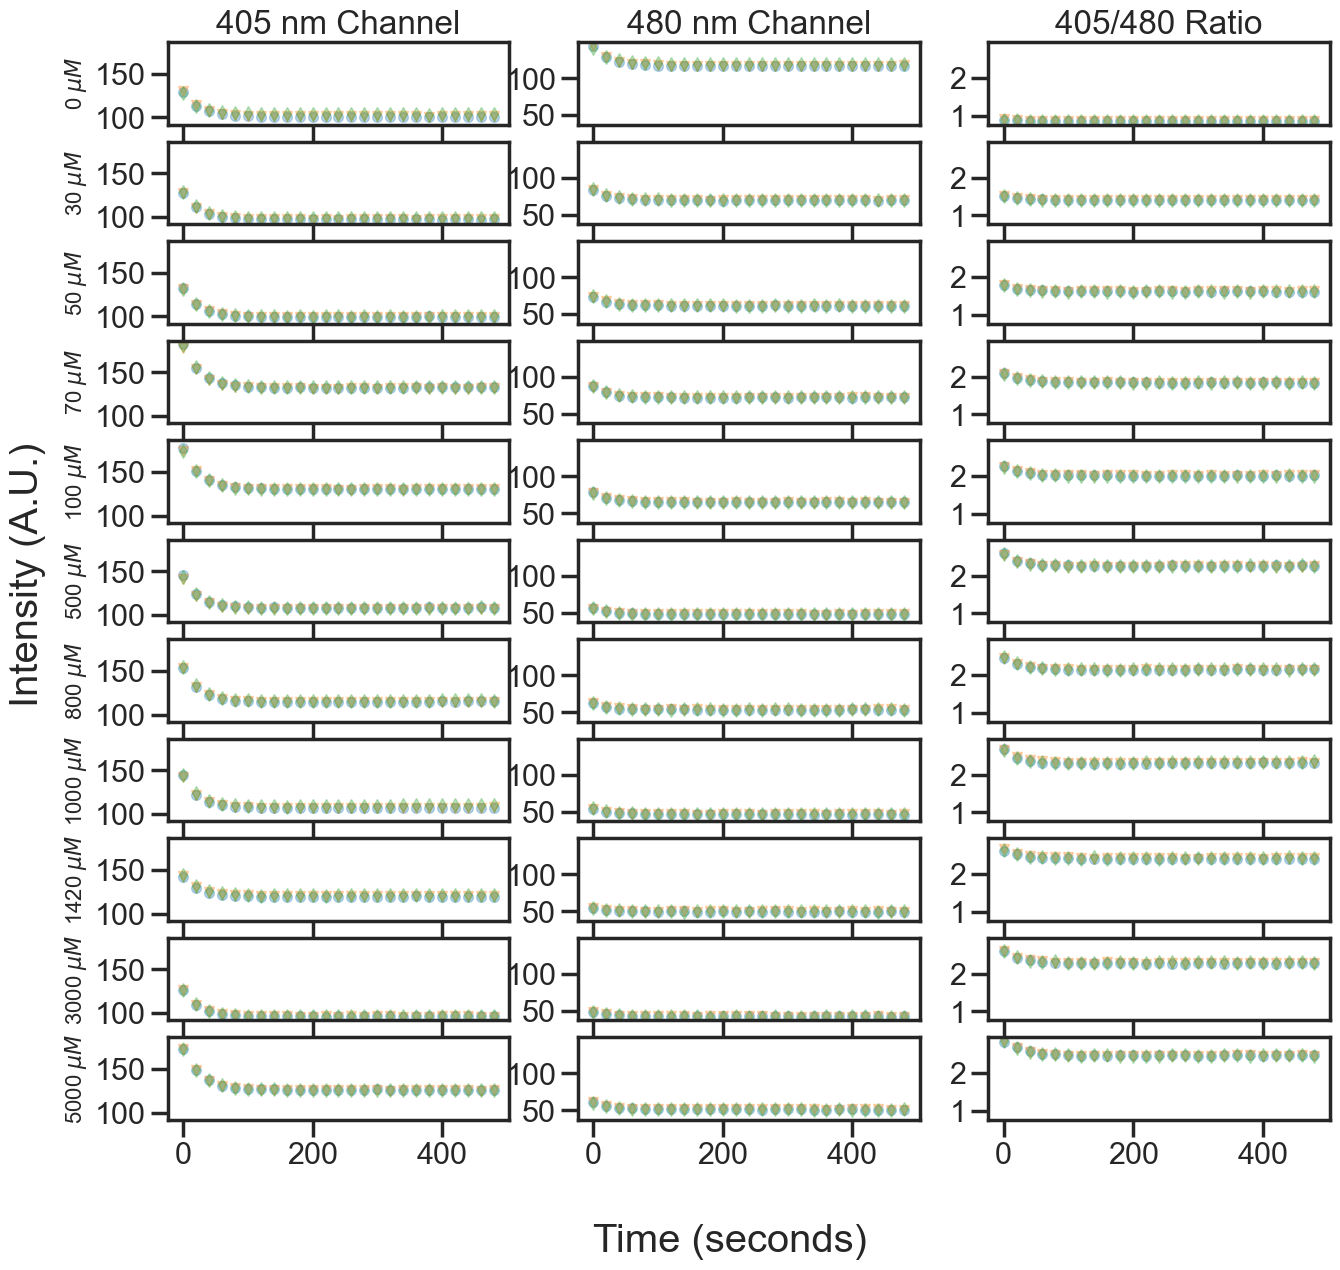

In [177]:
#2024 dataset
temptimes = np.arange(len(temparr))*20 #seconds
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(15,14), sharey='col')
markers = ['o', 'v','d']
for a, atp in enumerate(ATPconcs24):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col, colname in enumerate(['405', '480', 'ratio']):
            #if col<2:
            ax[a][col].plot(temptimes, evenedResults24[(atp, pos, colname)], marker=markers[pos], ms=7, lw=0, alpha=0.3) 
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 nm Channel')
ax[0][1].set_title('480 nm Channel')
ax[0][2].set_title('405/480 Ratio')
#ax[-1][1].set_xlabel('Time (seconds)')
fig.supylabel('Intensity (A.U.)')
fig.supxlabel('Time (seconds)')
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250125intensityVsTime.pdf')

Text(0.5, 0, 'time')

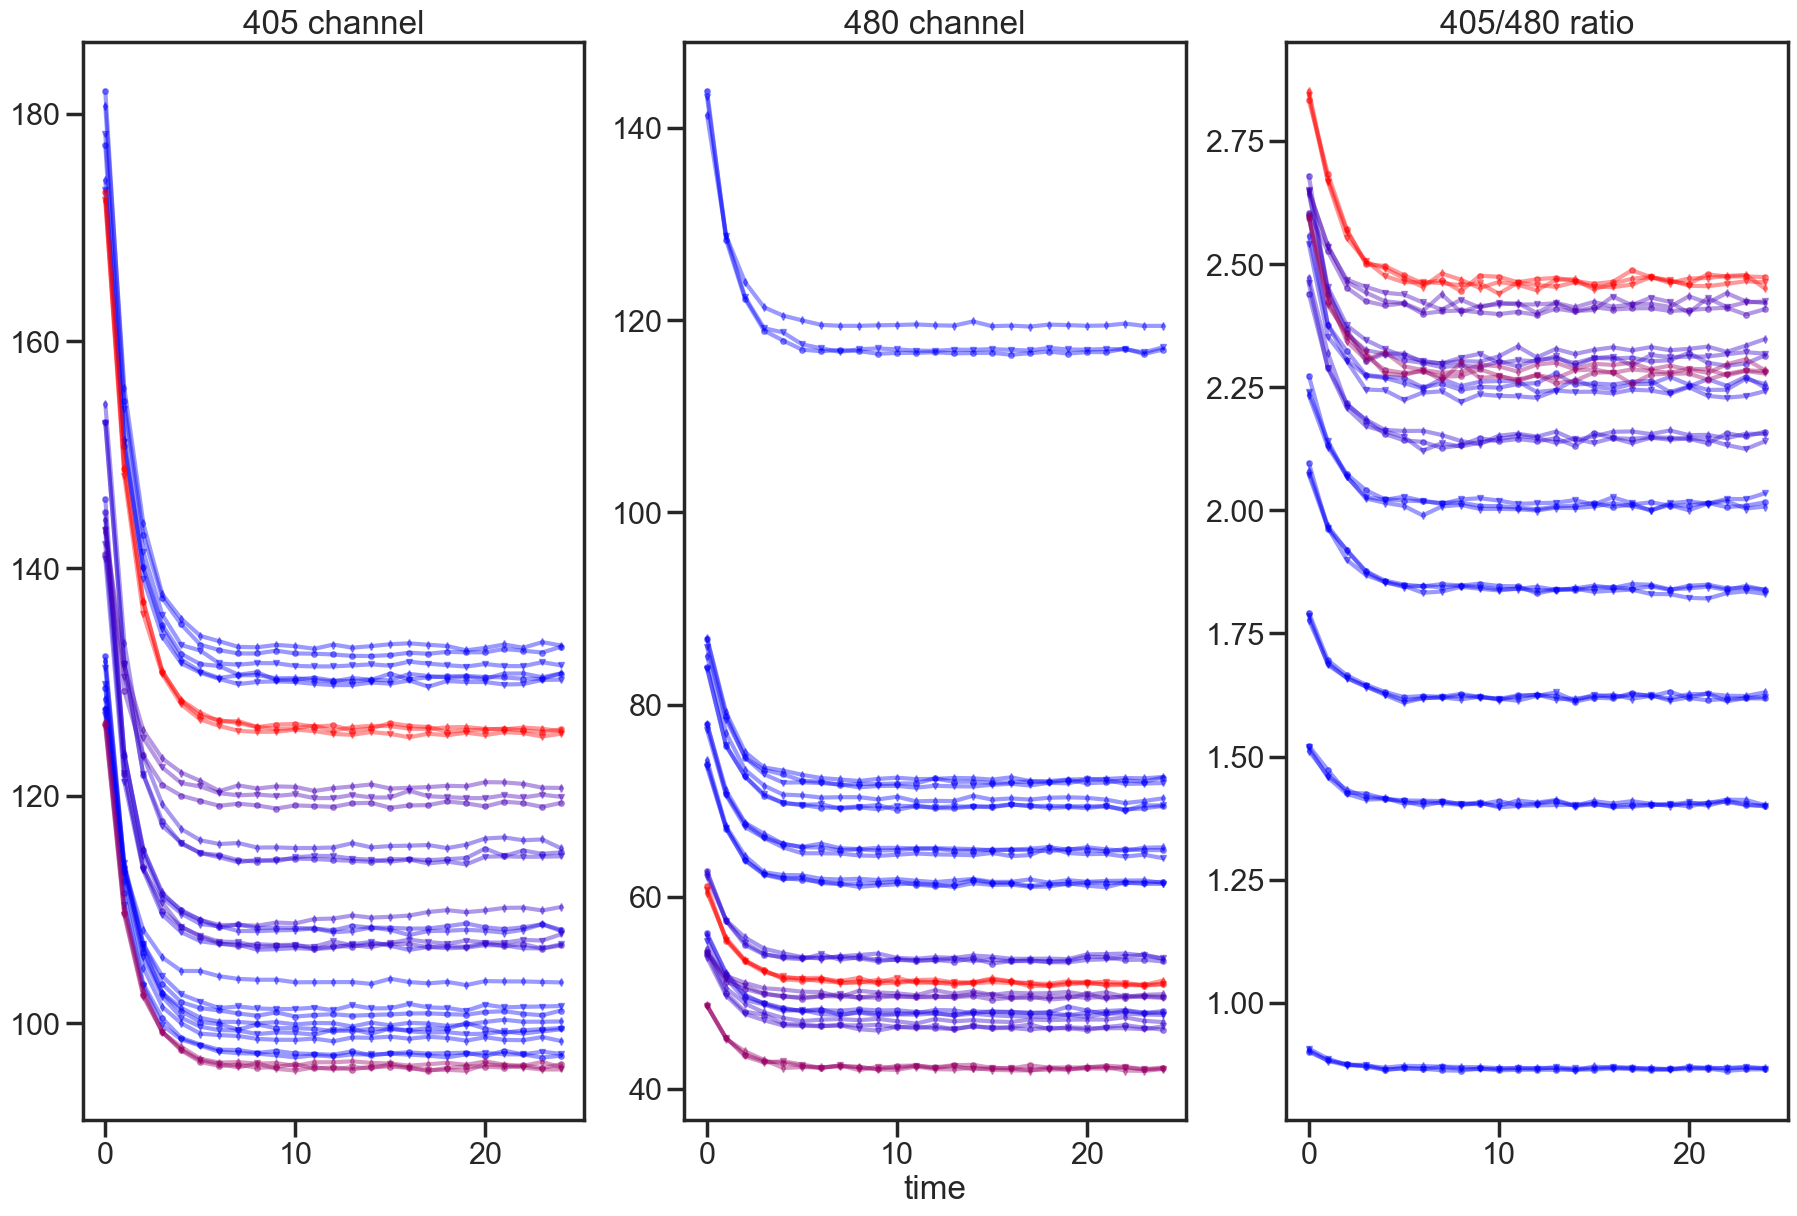

In [131]:
#2024 dataset
fig, ax = plt.subplots(1,3, figsize=(22,14), sharey='col')
markers = ['o', 'v','d']
for a, atp in enumerate(ATPconcs24):
    for pos in range(3):
        for col, colname in enumerate(['405', '480', 'ratio']):
            #if col<2:
            ax[col].plot(evenedResults24[(atp, pos, colname)], marker=markers[pos], ms=4, alpha=0.4, color=(atp/ATPconcs24.max(), 0, 1-atp/ATPconcs24.max(), 0.8)) 
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0].set_title('405 channel')
ax[1].set_title('480 channel')
ax[2].set_title('405/480 ratio')
ax[1].set_xlabel('time')

Text(0.5, 0, 'time')

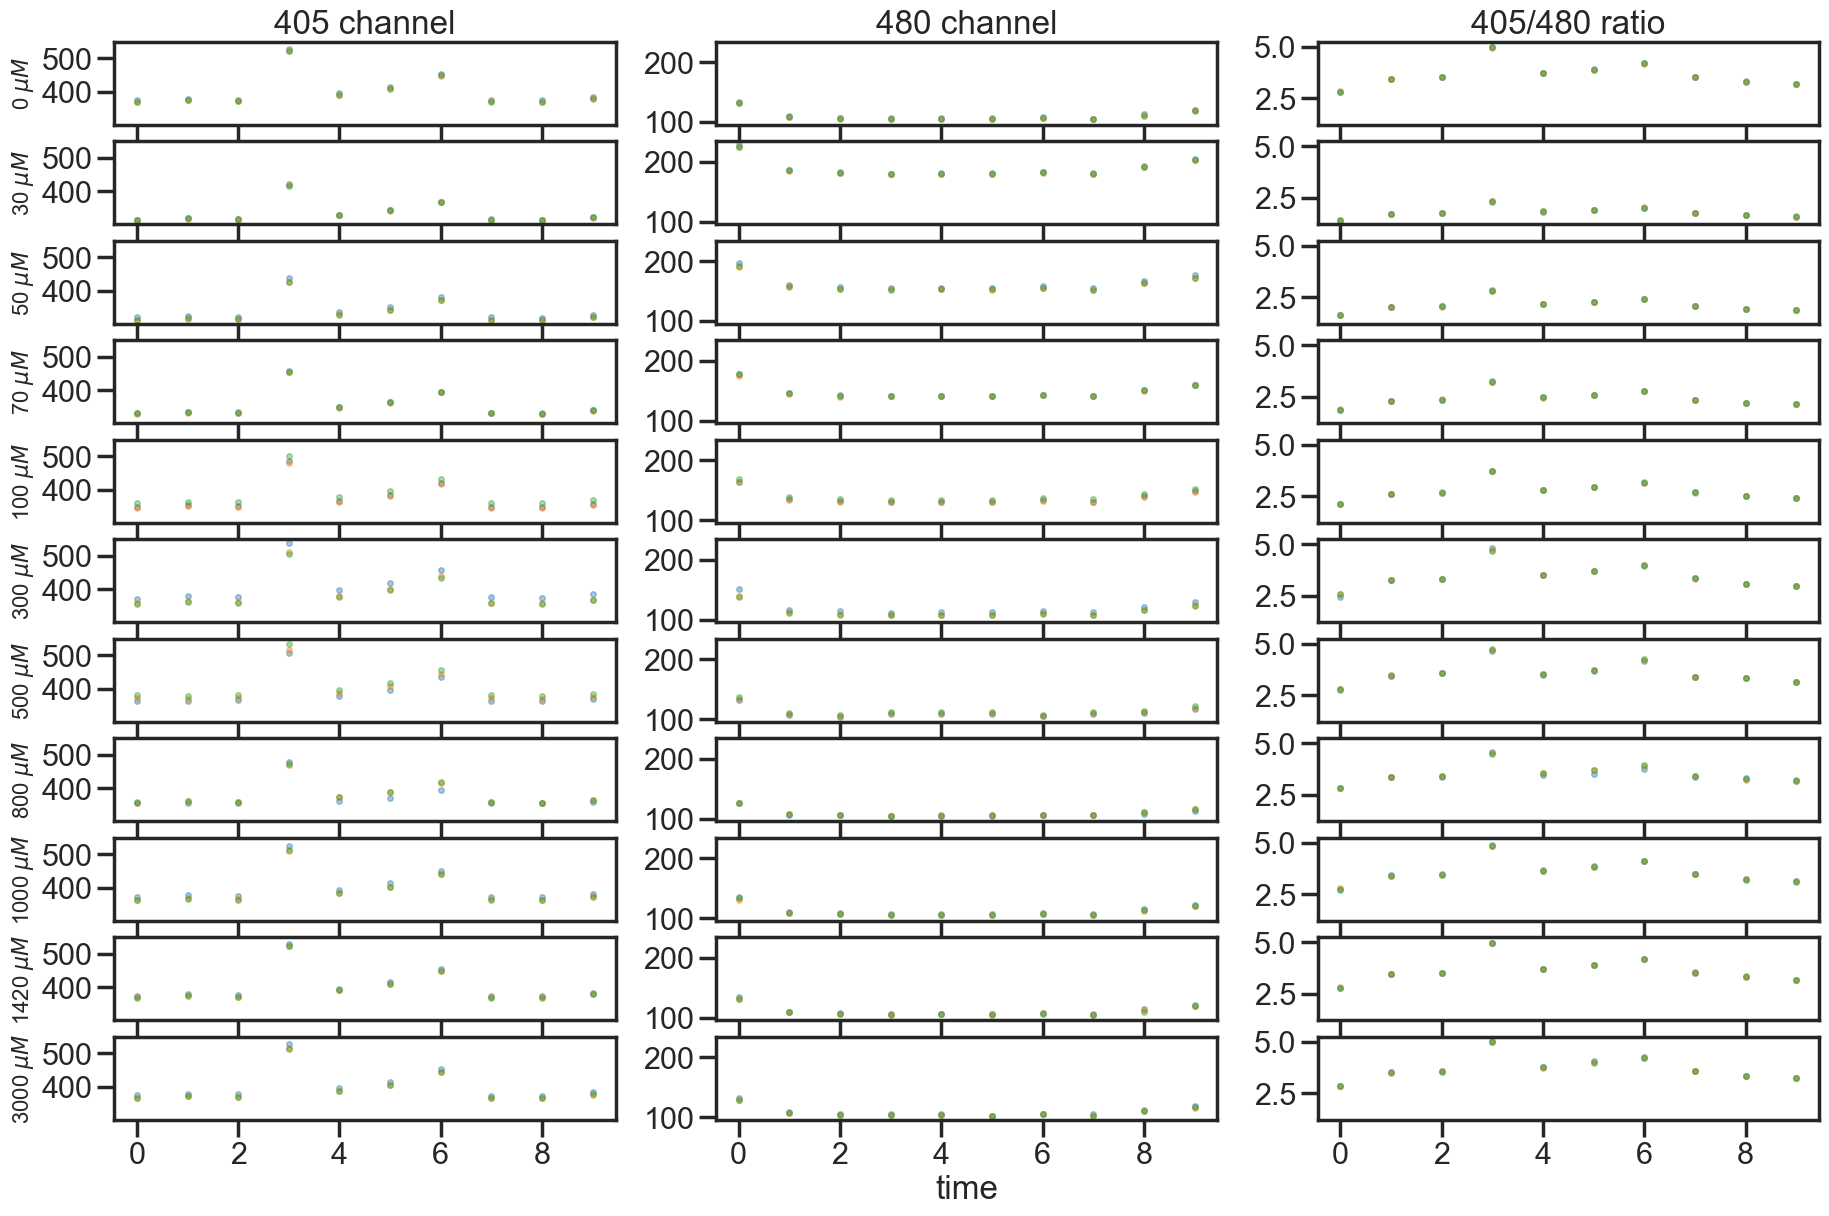

In [18]:
#2023 dataset
fig, ax = plt.subplots(len(ATPconcs23),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs23):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col, colname in enumerate(['405', '480', 'ratio']):
            #if col<2:
            ax[a][col].plot(evenedResults23[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

## Fitting 

20250123 for now i will just look at fitting the 2024 data

In [78]:
tol=1e-7 #if you want to set a precision to the solver

def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1], where w1 is the weight of the exponential, 
        tau1 is the decay constant of the exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]

    return w1*np.exp(-times/tau1)
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def singExpConst(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential,
        tau1 is the decay constant of the exponential and w2 is the limit of the intensity as you go to infinity
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]

    return w1*np.exp(-times/tau1)+w2
    
def singExpConstFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(w2) is the weight of the first(second) exponential, 
        tau1(tau2) is the decay constant of the first(second) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def tripExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2, w3, tau3], where w1(w2,w3) is the weight of the first(second, third) exponential, 
        tau1(tau2, tau3) is the decay constant of the first(second, third) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]
    w3 = p0[4]
    tau3 = p0[5]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)+w3*np.exp(-times/tau3)
    
def tripExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-tripExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

In [274]:
temparr = evenedResults24[(500, 2, '405')]
tempevenarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds

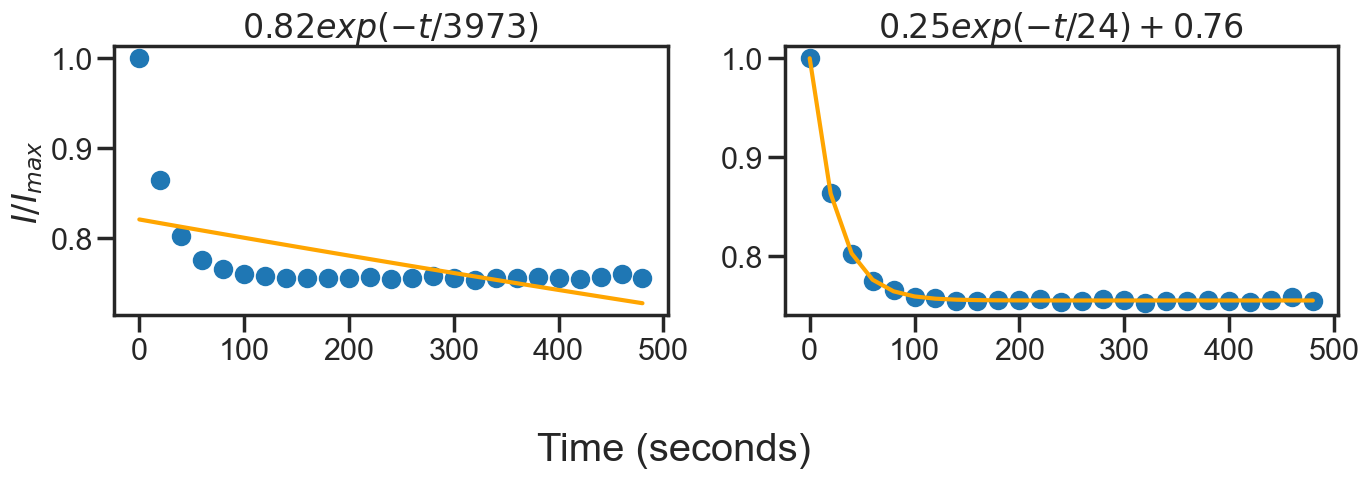

In [275]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

#Single Exponential
tempfit = singExpFit(temptimes, tempevenarr, [0.7, 2000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
ax[0].scatter(temptimes, tempevenarr)
ax[0].plot(temptimes, singExp(temptimes, tempfit.x), ls='-', label='Single Exponential', color='orange')
ax[0].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})$')#[round(p,2) for p in tempfit.x], fontsize=15)
#ax[0].set_title([round(p,2) for p in tempfit.x], fontsize=15)
#ax[0].legend(fontsize=10)
#print('single exp')
#print(tempfit)

#Single Exponential + Constant
tempfit = singExpConstFit(temptimes, tempevenarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
ax[1].scatter(temptimes, tempevenarr)
ax[1].plot(temptimes, singExpConst(temptimes, tempfit.x), ls='-',label='Single+Constnat Exponential', color='orange')
#ax[1].set_title([round(p,2) for p in tempfit.x], fontsize=15)
ax[1].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})+{round(tempfit.x[2],2)}$')

#ax[1].legend(fontsize=10)
#print('\n single exp + const')
#print(tempfit)

# #Double Exponential
# tempfit = doubExpFit(temptimes, tempevenarr, [0.2, 25, 0.8, 10000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
# ax[2].scatter(temptimes, tempevenarr)
# ax[2].plot(temptimes, doubExp(temptimes, tempfit.x), ls='-', label='Double Exponential', color='orange')
# #ax[2].set_title([round(p,2) for p in tempfit.x], fontsize=15)
# ax[2].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})+{round(tempfit.x[2],2)} exp({{-t/{round(tempfit.x[3])}}})$')
# #ax[2].legend(fontsize=10)
# #print('\n double exp')
# #print(tempfit)

# #Triple Exponential
# tempfit = tripExpFit(temptimes, tempevenarr, [0.2, 25, 0.5, 1e4, 0.3, 1e7])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
# ax[3].scatter(temptimes, tempevenarr)
# ax[3].plot(temptimes, tripExp(temptimes, tempfit.x), ls='--', label='Triple Exponential', color='orange')
# ax[3].legend(fontsize=10)
# ax[3].set_title([round(p,2) for p in tempfit.x], fontsize=15)#(100, 0.9, [round(p,2) for p in tempfit.x], fontsize=20)
# print('\n triple exp ')
# print(tempfit)

ax[0].set_ylabel(f'$I/I_{{max}}$')
fig.supxlabel('Time (seconds)')
plt.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126multiFits.pdf')

In [329]:
np.sum((tempevenarr-singExpConst(temptimes, tempfit_spc.x)**2))

4.323119418164125

#### fit tau 2 based on single exponential+constant

In [276]:
#--------------------------------------------------------------------#
def doubExpT2(times, fixed_params, tau2):
    """
    times: array of time points
    fixed_params: parameters for [w1, tau1, w2]
    tau2: initial parameter value guess for the decay constant of the second exponential 
    """
    w1 = fixed_params[0]
    tau1 = fixed_params[1]
    w2 = fixed_params[2]
   
    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpT2Fit(times, fixed_params, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExpT2(times, fixed_params, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

In [277]:
#Single Exponential + Constant
tempfit_spc = singExpConstFit(temptimes, tempevenarr, [0.2, 25, 0.8])
tempfit_spc.x

array([ 0.24500649, 24.42532402,  0.75523681])

In [310]:
2%3

2

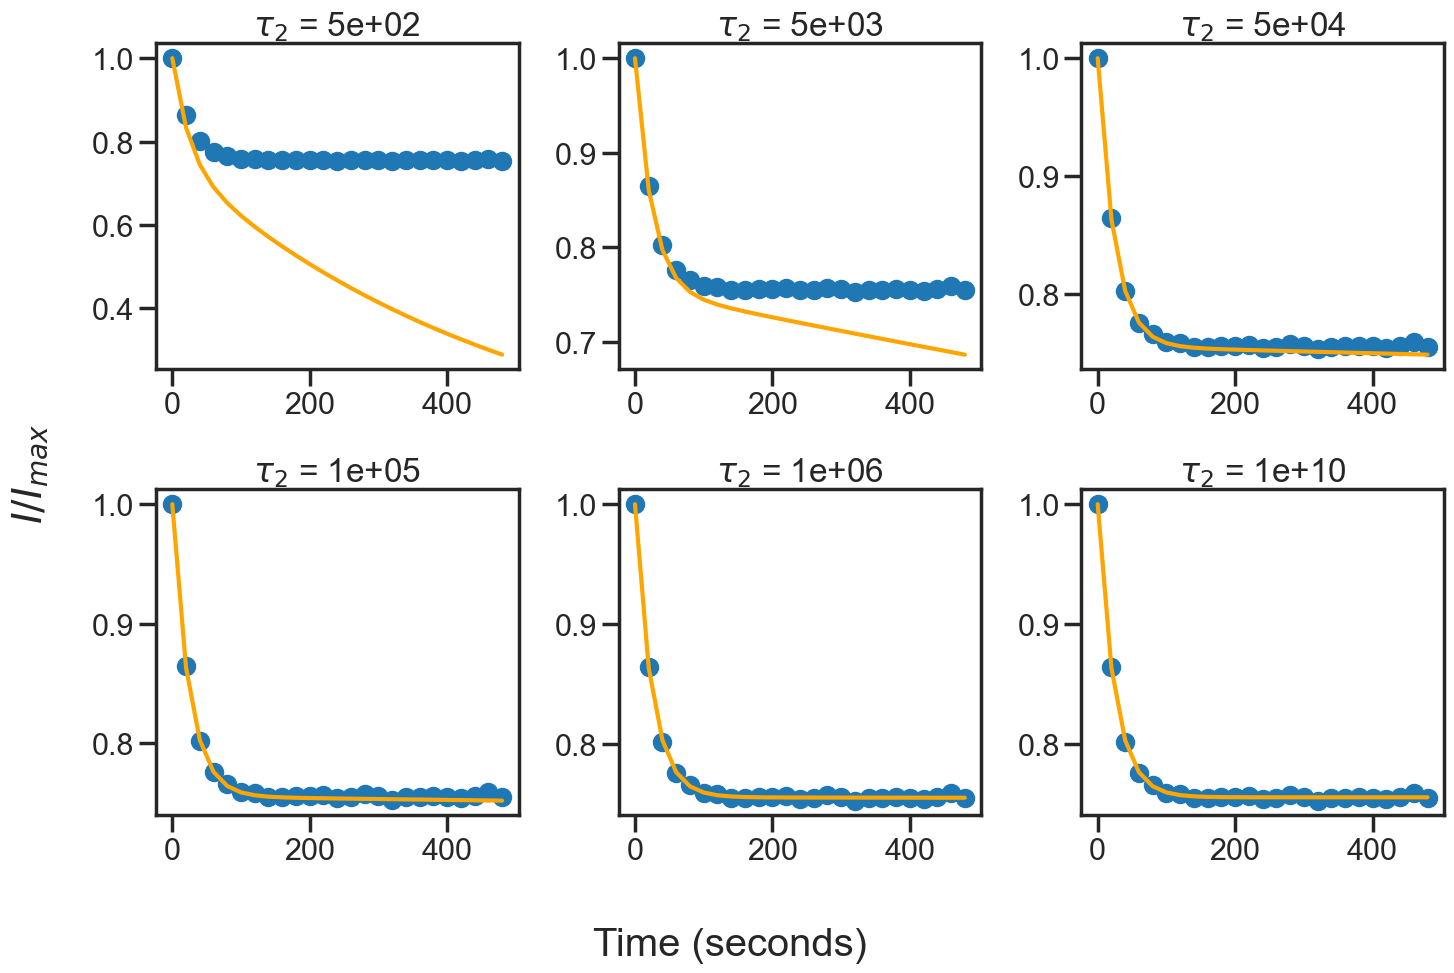

In [327]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
tau2 = [5e2, 5e3, 5e4, 1e5, 1e6, 1e10]
for i in range(6):
    ax[int(i/3)][i%3].scatter(temptimes, tempevenarr)
    ax[int(i/3)][i%3].plot(temptimes, doubExpT2(temptimes, tempfit_spc.x, tau2=tau2[i]), ls='-', label='Double Exponential', color='orange')
    ax[int(i/3)][i%3].set_title(r'$\tau_2$ = '+"{:.0e}".format(tau2[i]))#str(round(tau2[i])))
fig.supylabel(f'$I/I_{{max}}$')
fig.supxlabel('Time (seconds)')
plt.tight_layout()

#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126rangeT2.pdf')

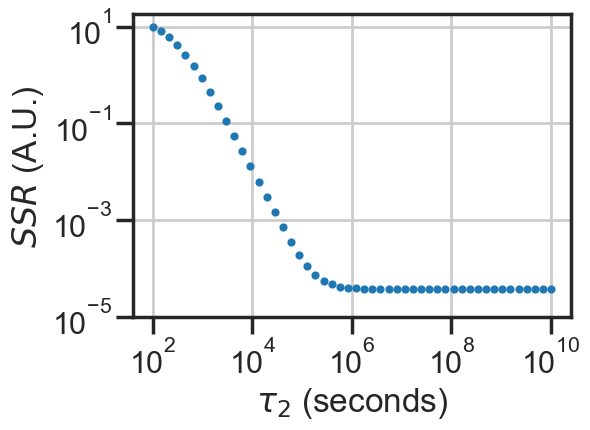

In [282]:
tau2array = np.logspace(2, 10, num=50)
plt.scatter(tau2array, [np.sum((tempevenarr-doubExpT2(temptimes, tempfit_spc.x, tau2=tau2))**2) for tau2 in tau2array], s=15)
plt.xscale('log')
plt.yscale('log')
plt.xticks(np.logspace(2, 10, num=5))
plt.yticks(np.logspace(1, -5, num=4))
plt.grid()
plt.xlabel(r'$\tau_2$ (seconds)')
plt.ylabel(r'$SSR$ (A.U.)')
plt.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126minimizeT2.pdf')

### Fit to a double exponential

In [168]:
#fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
doubExpFitResults={} #store results of fit
maxVals = {} #store array maximums
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            plotarr = evenedResults24[(atp, pos, colname)]
            maxVals[atp, pos, colname] = plotarr.max() #store maximums
            plottimes = np.arange(len(plotarr))*20 #seconds 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            fit = doubExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min(), 100000))
            doubExpFitResults[atp, pos, colname] = fit
            
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
    
    
    

100%, time elapsed: 0 seconds 

In [169]:
np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k])

array([100000.0000172 , 100000.00002065, 100000.00001447, 100000.00000156,
       100000.00001363, 100000.00000787, 100000.00000681, 100000.00000966,
       100000.00001888, 100000.00001043, 100000.0000029 , 100000.00000106,
       100000.000006  , 100000.00000516, 100000.00000726, 100000.00001919,
       100000.00001514, 100000.00001374, 100000.00002988, 100000.00001621,
       100000.00001554, 100000.00001622, 100000.0000221 , 100000.00005954,
       100000.00004633, 100000.00000992, 100000.0000251 , 100000.00000763,
       100000.00000397, 100000.00000608,  99999.99999308,  99999.99999492,
        99999.99999119])

Text(0.5, 0, 'time')

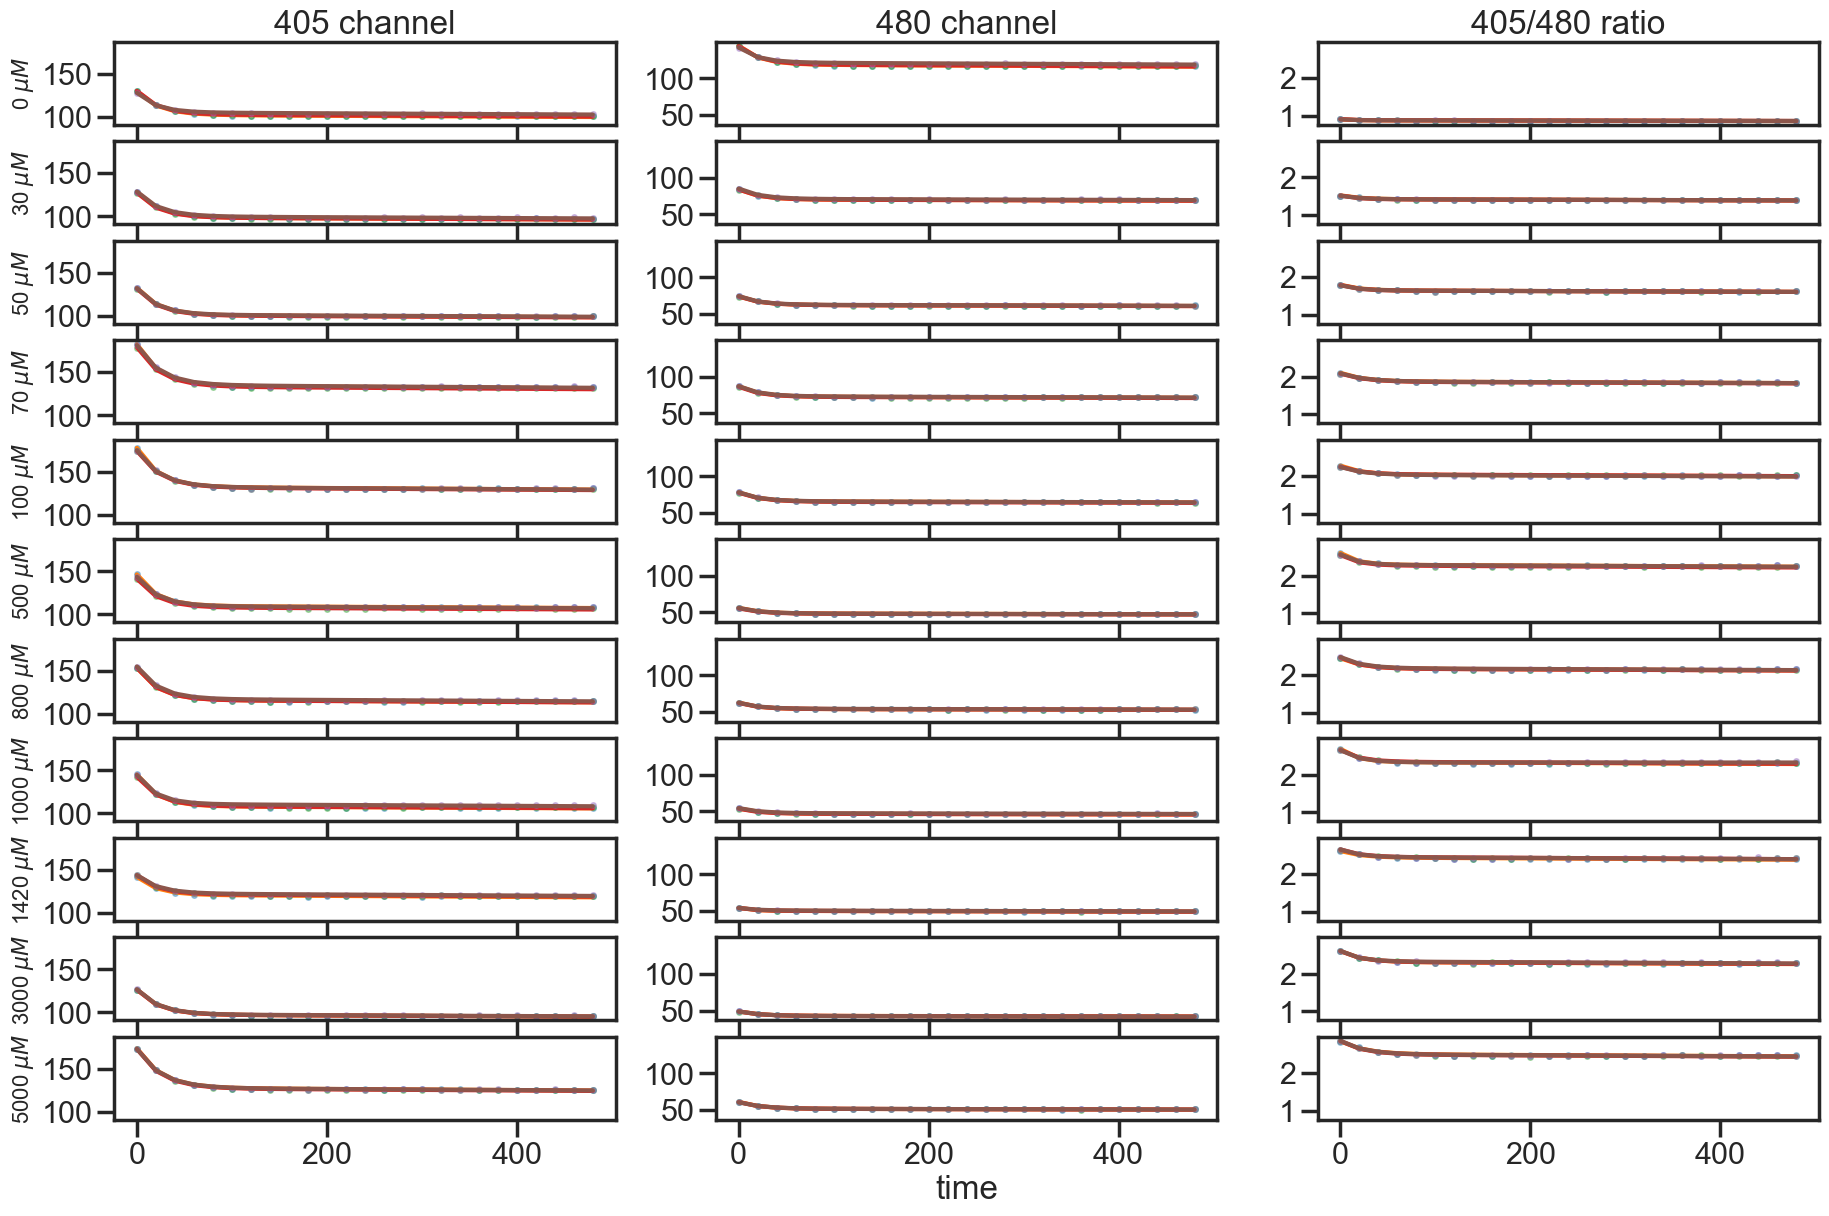

In [160]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr, 'o', ms=4, alpha=0.4) 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, doubExp(plottimes, doubExpFitResults[atp, pos, colname].x)*plotarr.max())
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Text(0.5, 0, 'time')

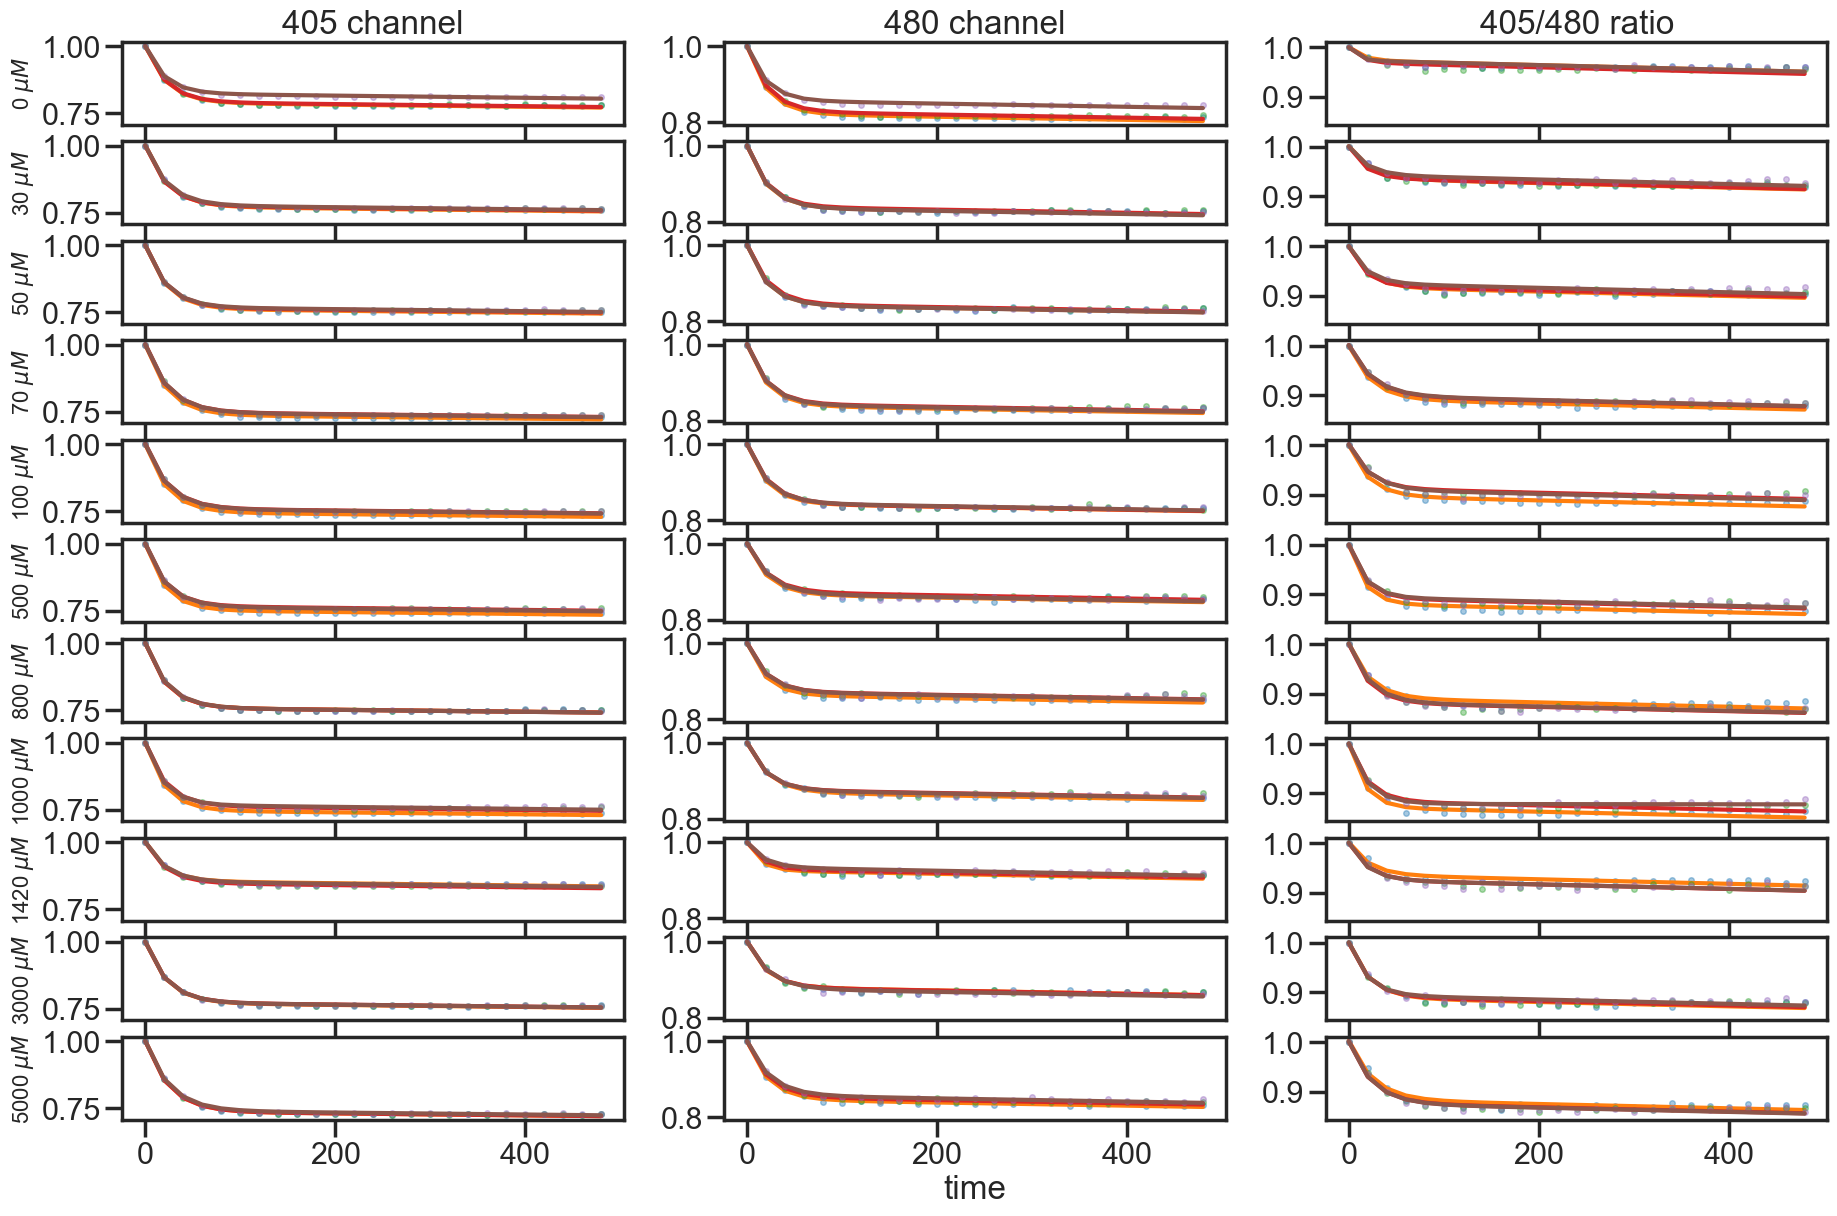

In [161]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4) 

        
            ax[a][col].plot(plottimes, doubExp(plottimes, doubExpFitResults[atp, pos, colname].x))
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [165]:
np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k])

array([20000.00171559, 20000.00175222, 20000.0024358 , 20000.00109654,
       20000.00143109, 20000.00128792, 20000.00116993, 20000.00130572,
       20000.00141246, 20000.00098591, 20000.0008976 , 20000.00086214,
       20000.00097727, 20000.00105354, 20000.0011269 , 20000.00133067,
       20000.00143758, 20000.00133419, 20000.00148583, 20000.00129829,
       20000.00131565, 20000.00124244, 20000.00155974, 20000.00231679,
       20000.00401623, 20000.00311069, 20000.00365472, 20000.00126328,
       20000.00118681, 20000.00121232, 20000.00056463, 20000.0006172 ,
       20000.0005766 ])

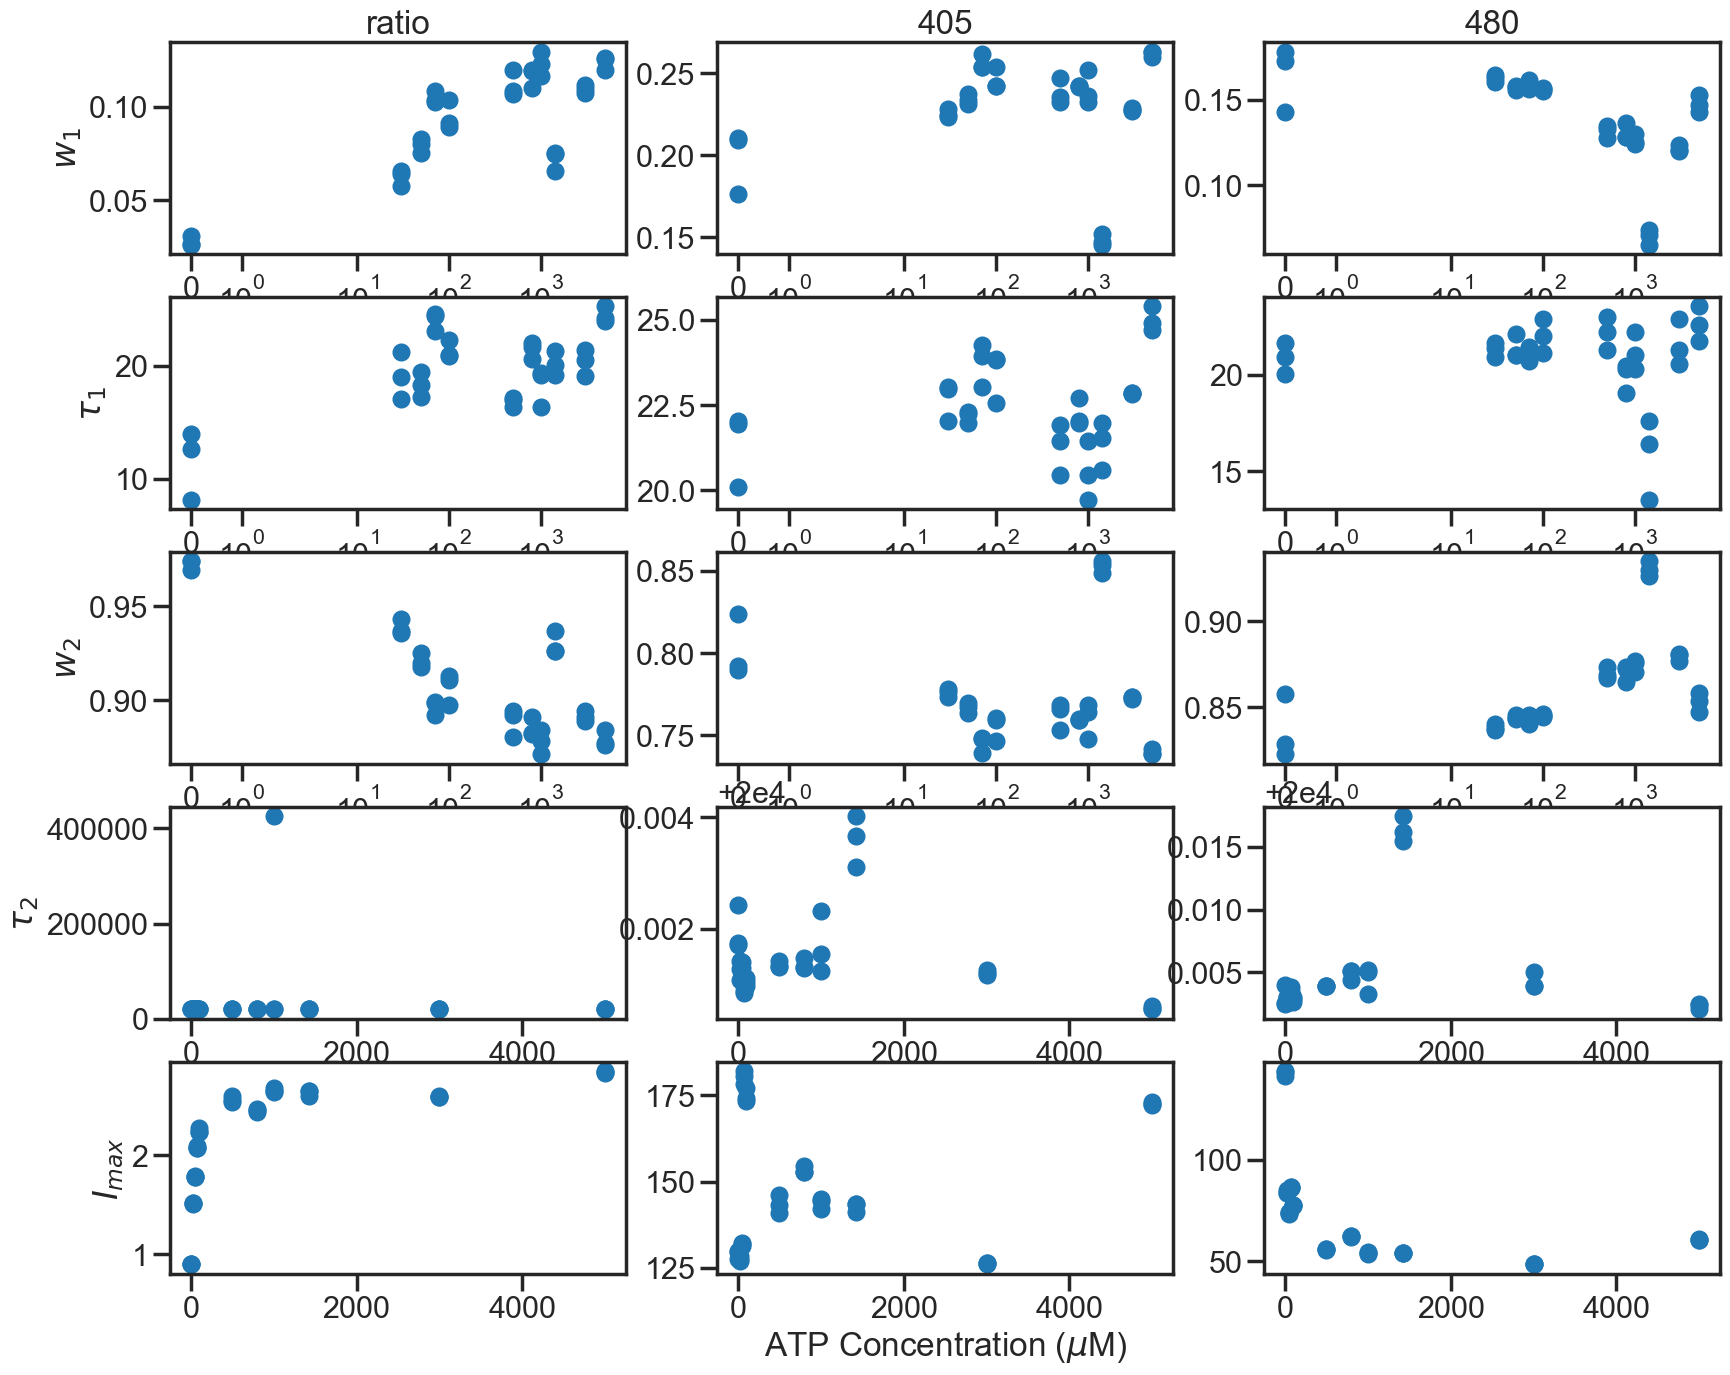

In [164]:
fig, ax = plt.subplots(5,3, figsize = (20, 16))

ax[0][0].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[0][1].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[0][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[0][0].set_ylabel(r'$w_1$')

ax[0][0].set_title('ratio')
ax[0][1].set_title('405')
ax[0][2].set_title('480')


ax[1][0].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[1][1].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[1][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[1][0].set_ylabel(r'$\tau_1$')

ax[2][0].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[2][1].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[2][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[2][0].set_ylabel(r'$w_2$')

ax[3][0].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[3][1].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[3][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[3][0].set_ylabel(r'$\tau_2$')

ax[4][0].plot(np.repeat(ATPconcs24,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[4][1].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[4][2].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[4][0].set_ylabel(r'$I_{max}$')


ax[4][1].set_xlabel(r'ATP Concentration ($\mu$M)')

for i in range(3):
    for j in range(3):
        ax[i][j].set_xscale('symlog')

### Do the Fit to single exponential + const and store max vals

In [154]:
#fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
singExpConstFitResults={} #store results of fit
maxVals = {} #store array maximums
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            plotarr = evenedResults24[(atp, pos, colname)]
            maxVals[atp, pos, colname] = plotarr.max() #store maximums
            plottimes = np.arange(len(plotarr))*20 #seconds 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            fit = singExpConstFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
            singExpConstFitResults[atp, pos, colname] = fit
            
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
    
    
    

100%, time elapsed: 0 seconds 

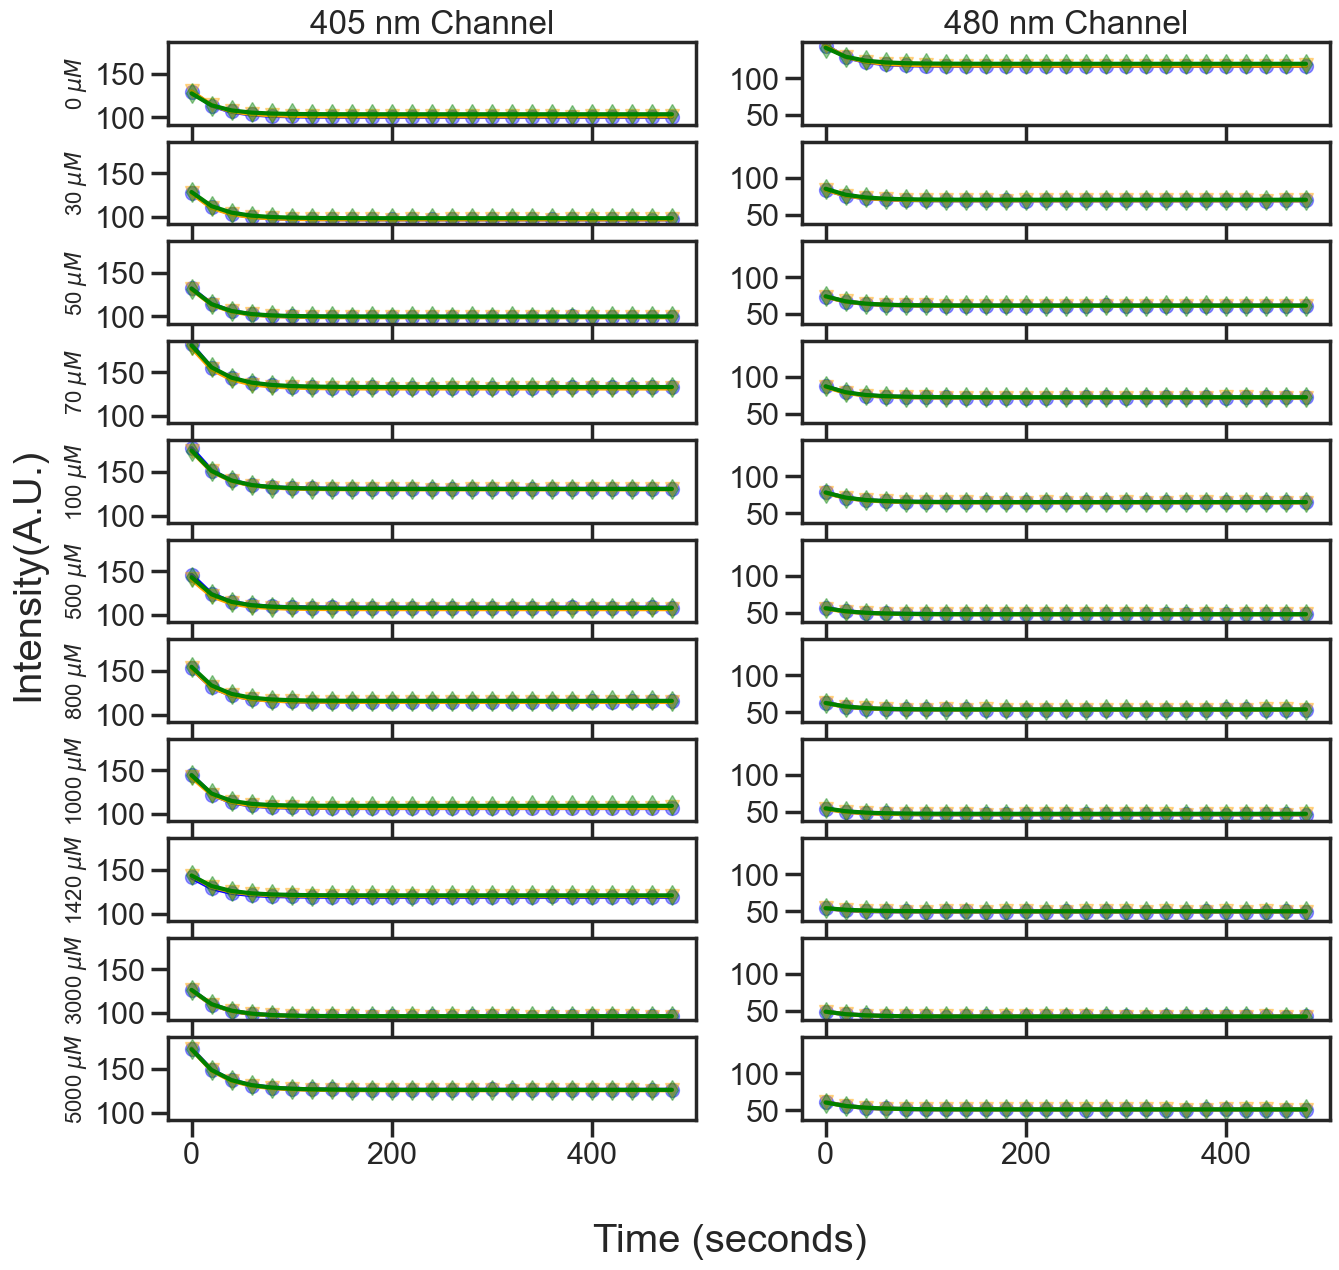

In [344]:
fig, ax = plt.subplots(len(ATPconcs24),2, figsize=(15,14), sharey='col')
markers = ['o', 'v','d']
linecolors = ['b', 'orange', 'g']
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480']): #, 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr, marker=markers[pos], ms=10, alpha=0.4, lw=0, color=linecolors[pos]) 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x)*plotarr.max(), color=linecolors[pos])
           
ax[0][0].set_title('405 nm Channel')
ax[0][1].set_title('480 nm Channel')
# ax[0][2].set_title('405/480 ratio')
fig.supxlabel('Time (seconds)')
fig.supylabel('Intensity(A.U.)')
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126FittedSingConst.pdf')

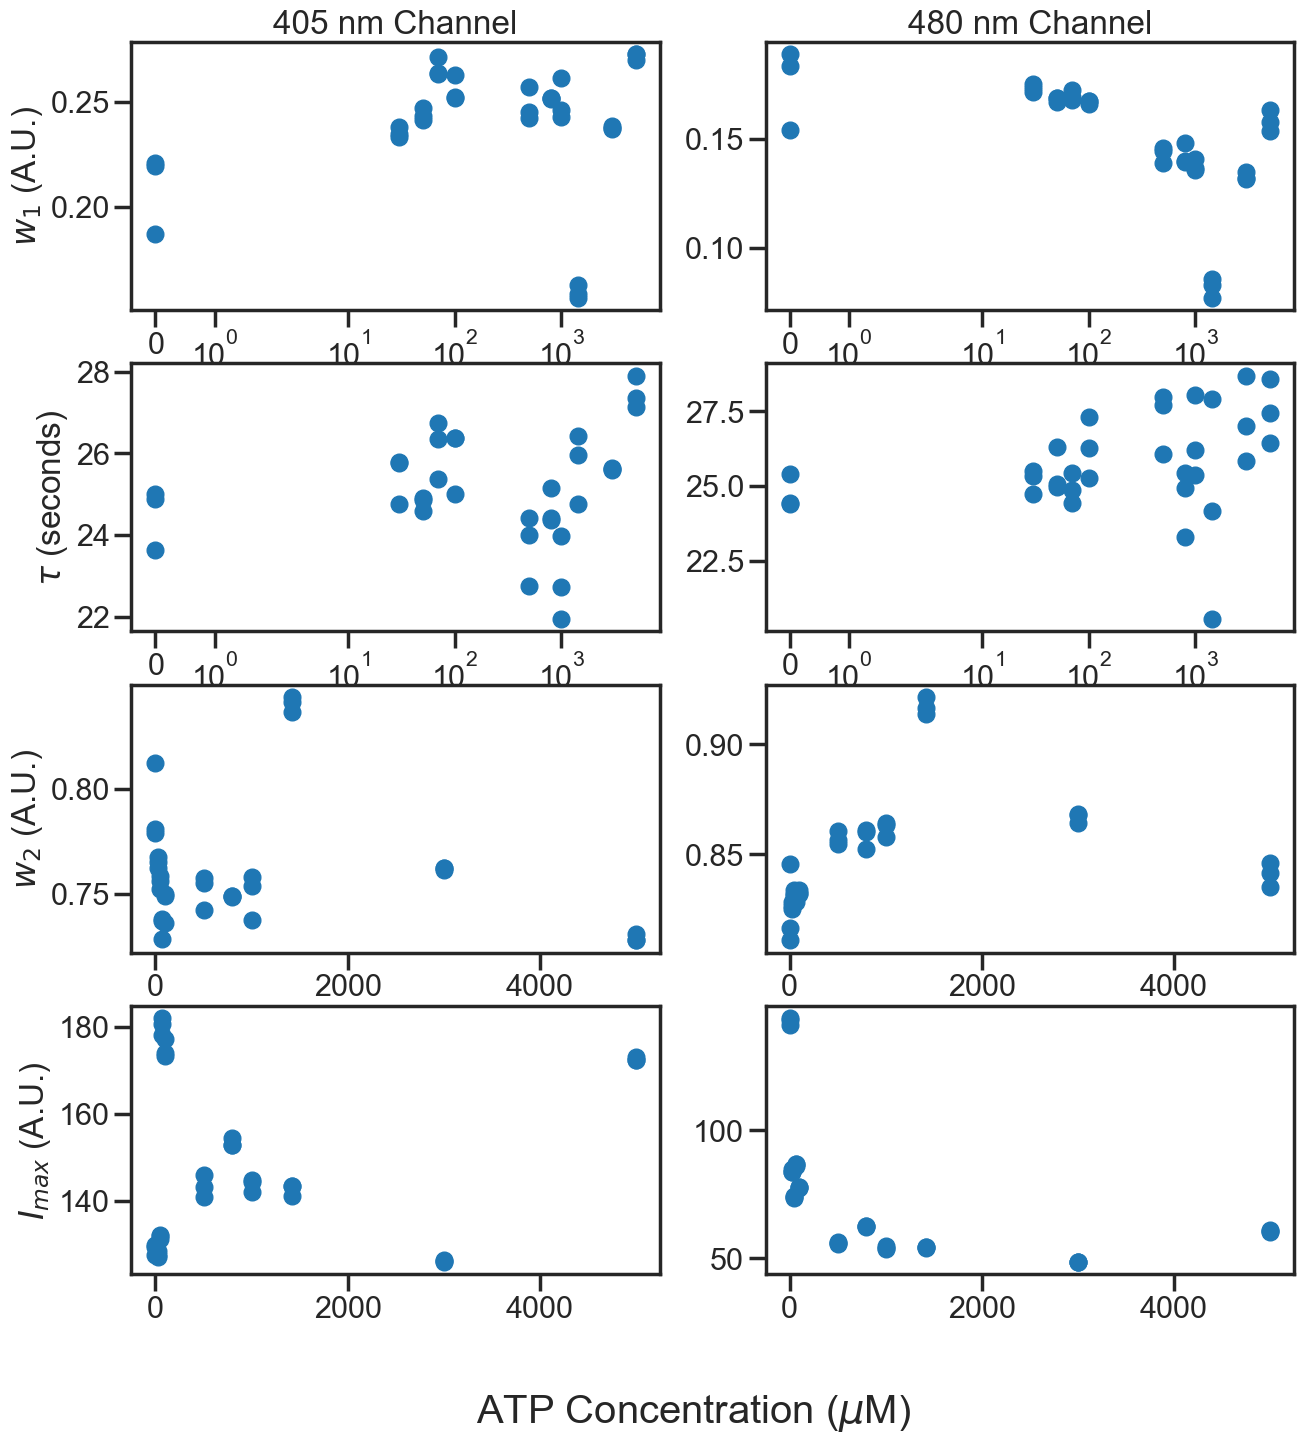

In [351]:
fig, ax = plt.subplots(4,2, figsize = (15, 16))

#ax[0][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[0][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[0][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[0][0].set_ylabel('$w_1$ (A.U.)')

#ax[0][0].set_title('ratio')
ax[0][0].set_title('405 nm Channel')
ax[0][1].set_title('480 nm Channel')


#ax[1][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[1][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[1][0].set_ylabel(r'$\tau$ (seconds)')

#ax[2][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[2][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[2][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[2][0].set_ylabel(r'$w_2$ (A.U.)')

#ax[3][0].plot(np.repeat(ATPconcs24,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[3][0].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[3][1].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[3][0].set_ylabel(r'$I_{max}$ (A.U.)')

fig.supxlabel(r'ATP Concentration ($\mu$M)')

for i in range(2):
    for j in range(2):
        ax[i][j].set_xscale('symlog')
        
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126paramVsATP.pdf')

Text(0.5, 0, 'time')

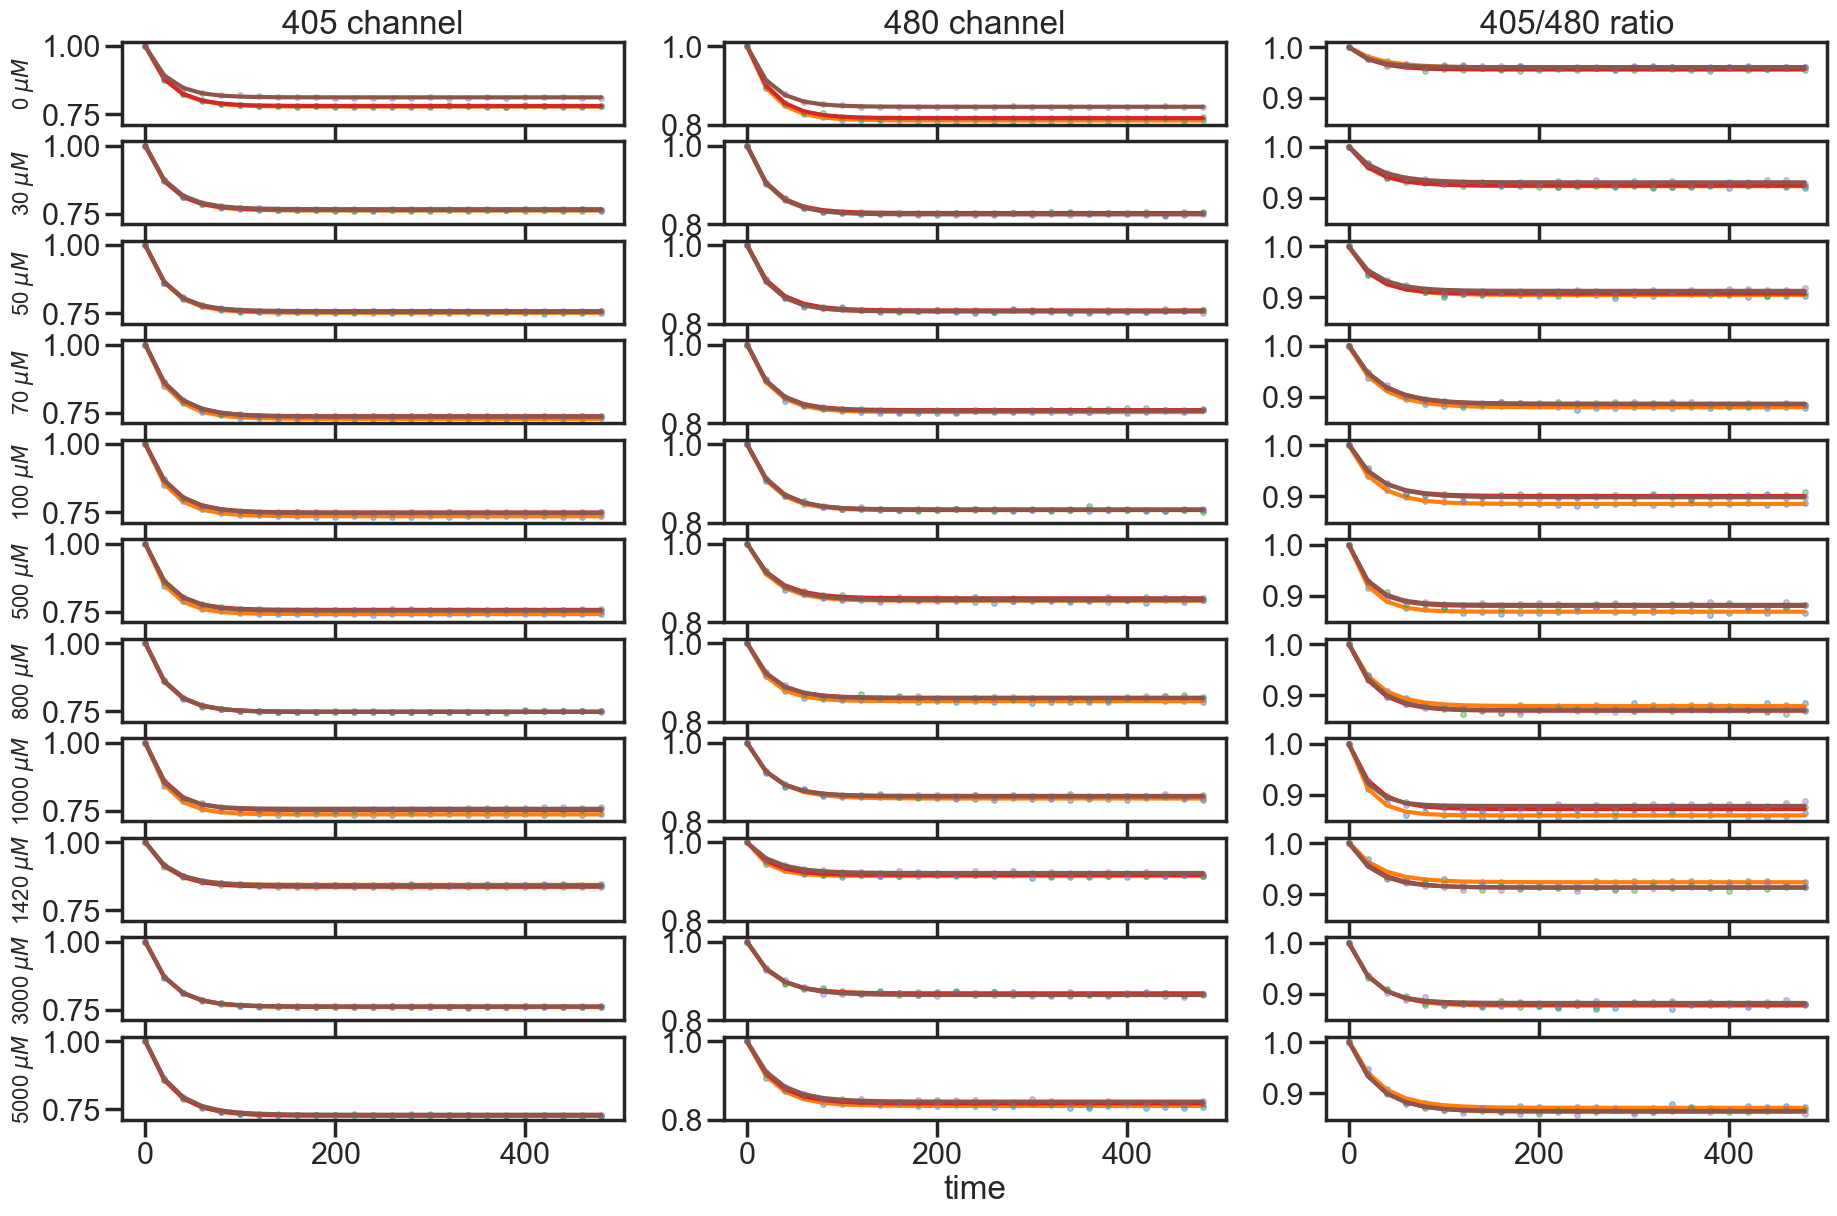

In [156]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4) 

        
            ax[a][col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x))
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

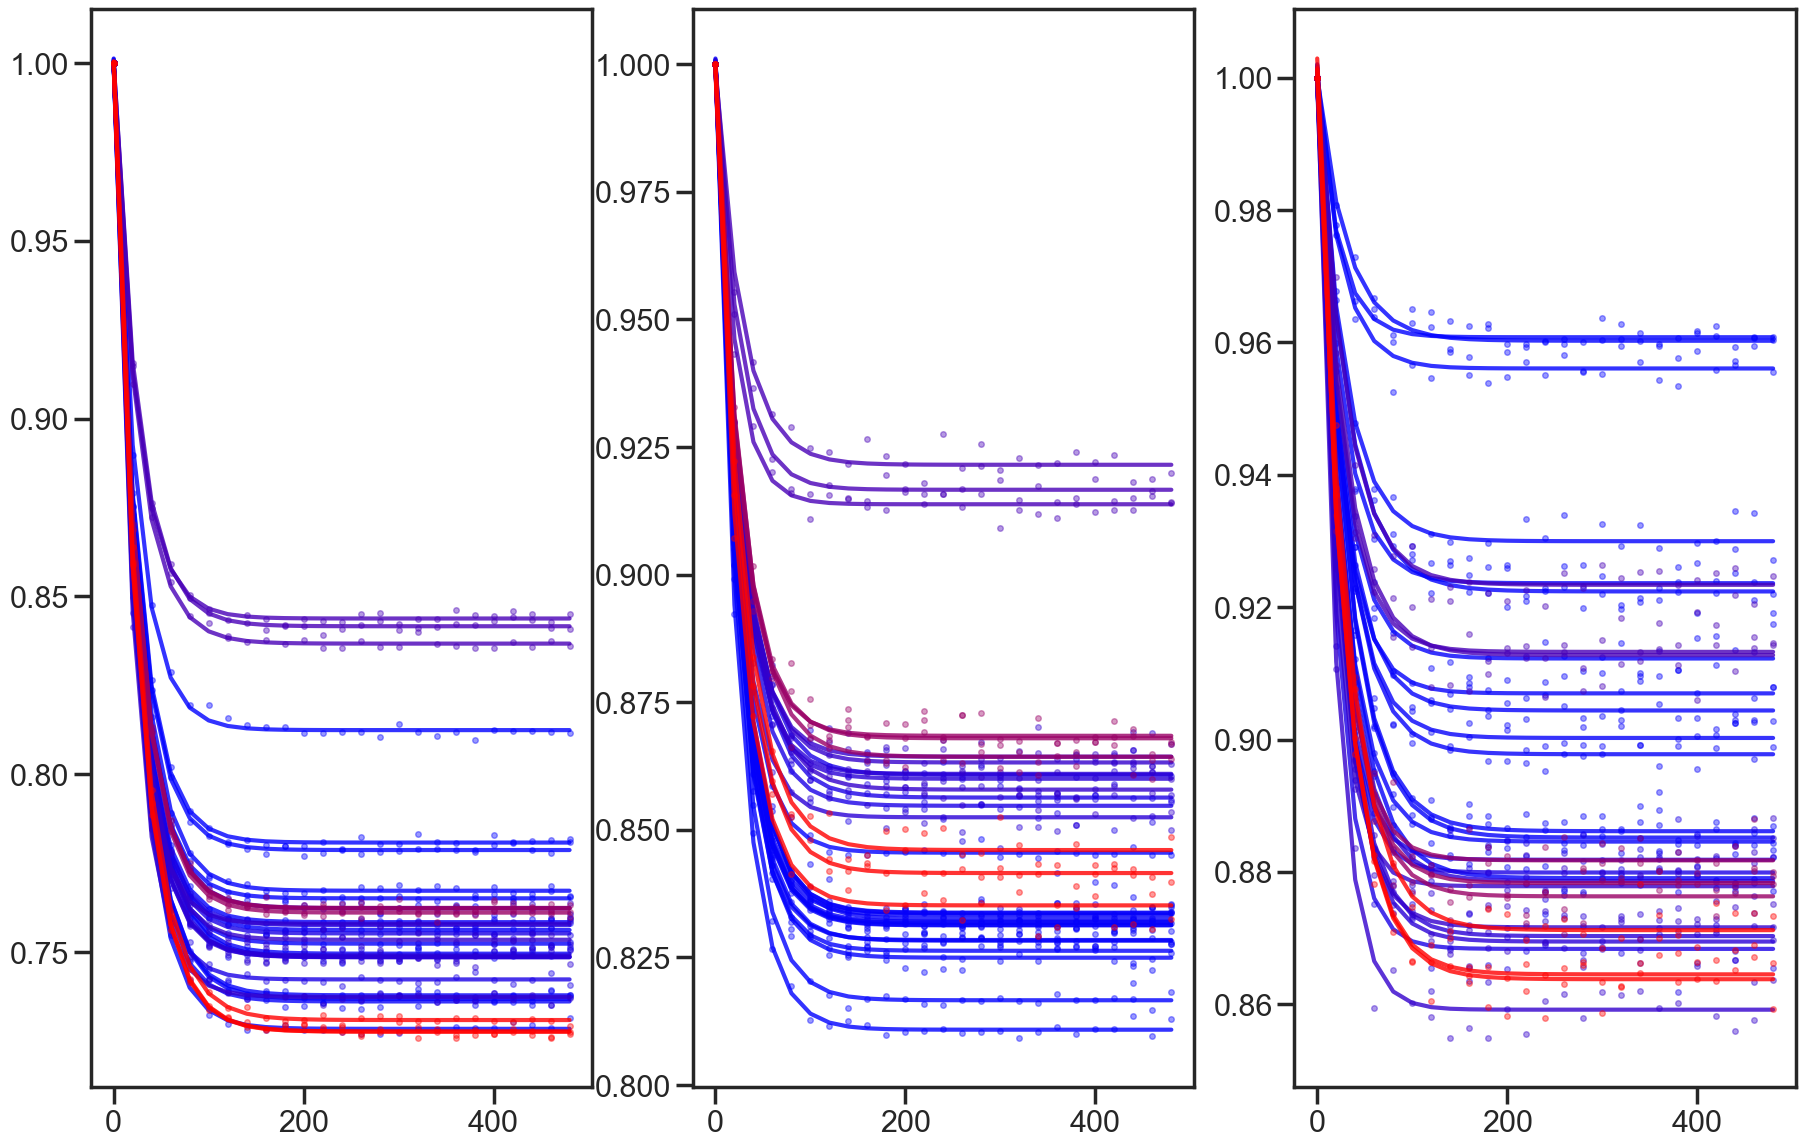

In [157]:
fig, ax = plt.subplots(1,3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4, color=(atp/ATPconcs24.max(), 0, 1-atp/ATPconcs24.max(), 0.8)) 

        
            ax[col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x), color=(atp/ATPconcs24.max(), 0, 1-atp/ATPconcs24.max(), 0.8))
           
# ax[0][0].set_title('405 channel')
# ax[0][1].set_title('480 channel')
# ax[0][2].set_title('405/480 ratio')
# ax[-1][1].set_xlabel('time')

In [48]:
w1For405 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k])
tauFor405=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k])
intFor405=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k])

w1For480 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k])
tauFor480=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k])
intFor480=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k])

w1Forratio =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k])
tauForratio=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k])
intForratio=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k])

print(w1For405, tauFor405, intFor405)
print(w1For480, tauFor480, intFor480)
print(w1Forratio, tauForratio, intForratio)


0.24501234599103164 24.99999754107892 0.7552375357777457
0.15380049578055022 25.000003237233877 0.8453946803458241
0.11520954424900257 26.857834854297625 0.88457730184607


In [49]:
k=list(singExpFitResults.keys())[-1]
np.sqrt(np.diag(singExpFitResults[k].hess_inv))

array([7.00735563e-01, 2.97794537e+02, 1.60159766e-01])

In [106]:
k

(np.int64(5000), 0, 'ratio')

In [107]:
singExpFitResults[k].hess_inv

array([[ 4.95743866e-01, -6.52070247e+01, -1.94813429e-02],
       [-6.52070247e+01,  8.45664739e+04, -1.68917040e+01],
       [-1.94813429e-02, -1.68917040e+01,  2.57591440e-02]])

In [111]:
### Grab fit parameter uncertainty
unc_w1Forratio =[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[0] for k in singExpFitResults.keys() if 'ratio' in k]
unc_tauForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[1] for k in singExpFitResults.keys() if 'ratio' in k]
unc_intForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[-1] for k in singExpFitResults.keys() if 'ratio' in k]
#unc_tauForratio
unc_intForratio

[np.float64(0.15911570462063357),
 np.float64(0.15881599646686606),
 np.float64(0.15926975287717837),
 np.float64(0.16145441724086176),
 np.float64(0.15830565301176872),
 np.float64(0.15819791835076655),
 np.float64(0.1579910418184234),
 np.float64(0.1570166360156736),
 np.float64(0.1612510823221165),
 np.float64(0.15923997954917685),
 np.float64(0.16049655443813718)]

In [113]:
singExpFitResults[k].x[-1]

np.float64(0.8637799856019528)

In [53]:
np.repeat(ATPconcs,3)

array([   0,    0,    0,   30,   30,   30,   50,   50,   50,   70,   70,
         70,  100,  100,  100,  500,  500,  500,  800,  800,  800, 1000,
       1000, 1000, 1420, 1420, 1420, 3000, 3000, 3000, 5000, 5000, 5000])

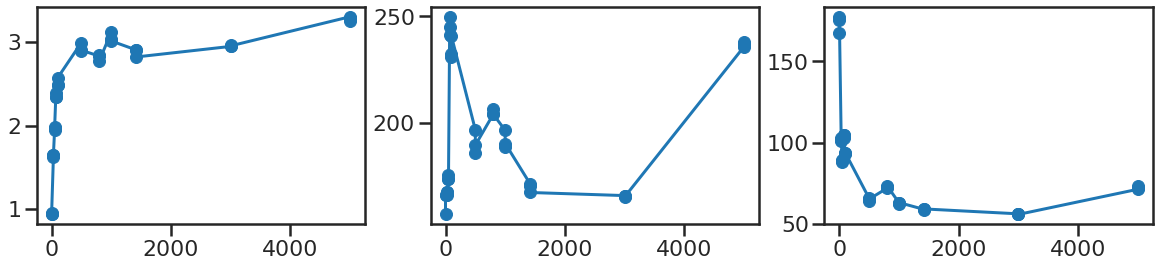

In [54]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


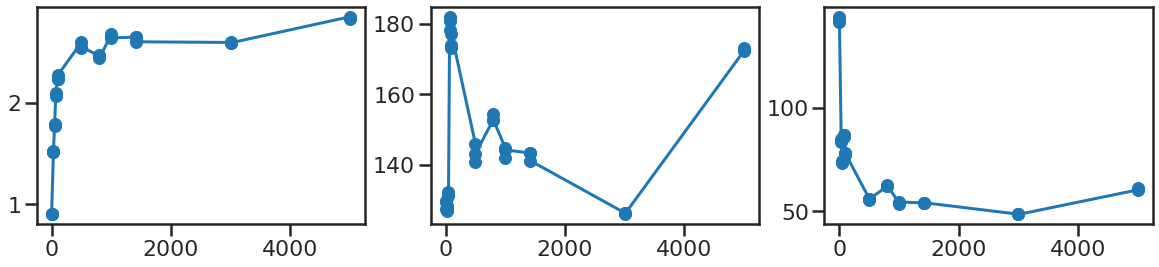

In [56]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) , 'o-',label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) , 'o-',label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) , 'o-', label='480') 


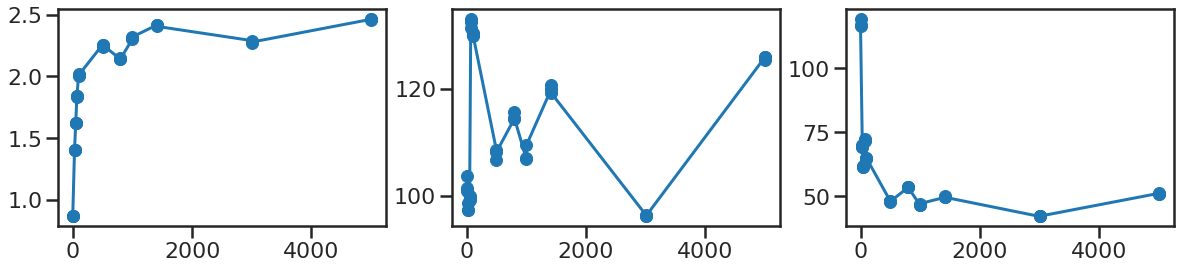

In [57]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


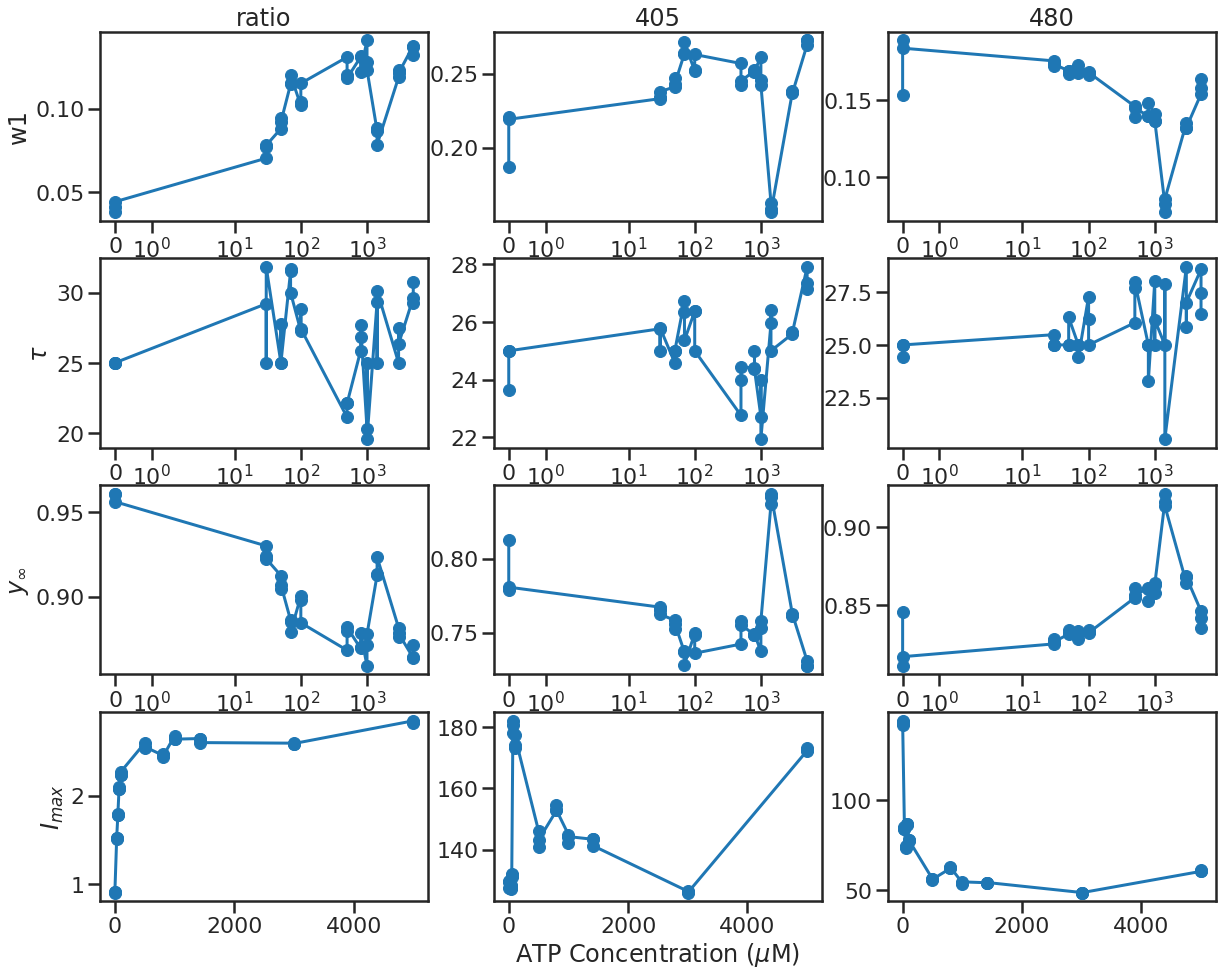

In [75]:
fig, ax = plt.subplots(4,3, figsize = (20, 16))

ax[0][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[0][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[0][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[0][0].set_ylabel('w1')

ax[0][0].set_title('ratio')
ax[0][1].set_title('405')
ax[0][2].set_title('480')


ax[1][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[1][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[1][0].set_ylabel(r'$\tau$')

ax[2][0].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[2][1].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[2][0].set_ylabel(r'$y_\infty$')

ax[3][0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[3][1].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405')
ax[3][2].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480') 
ax[3][0].set_ylabel(r'$I_{max}$')
ax[3][1].set_xlabel(r'ATP Concentration ($\mu$M)')

for i in range(3):
    for j in range(3):
        ax[i][j].set_xscale('symlog')

In [93]:
evenedResults[5000, 0, 'ratio'].max()/singExpFitResults[5000,0,'ratio'].x[2]


np.float64(3.3015130717811285)

KeyError: (1, 0, '405')

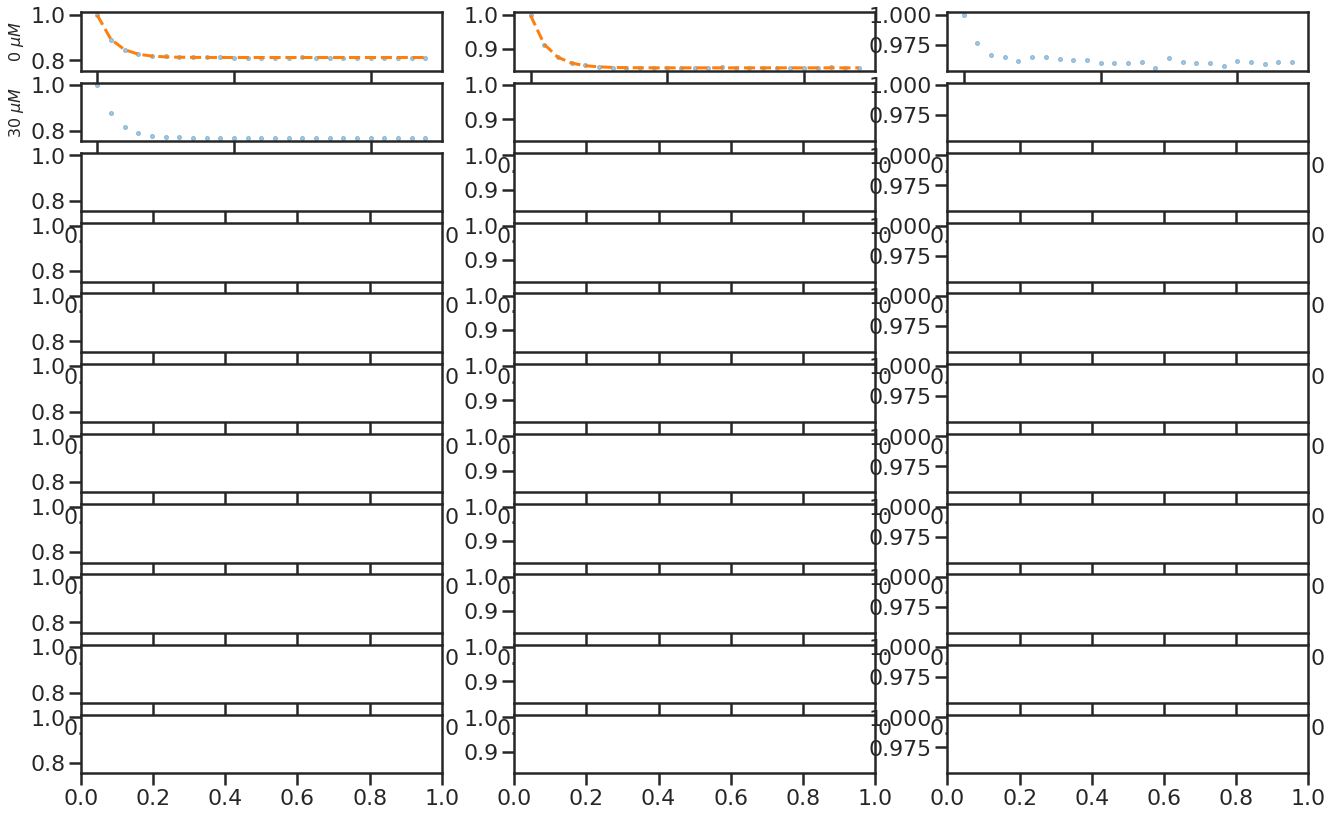

In [61]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            if col<2:
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, colname)].x), ls='--')

KeyError: (0, 0, 0)

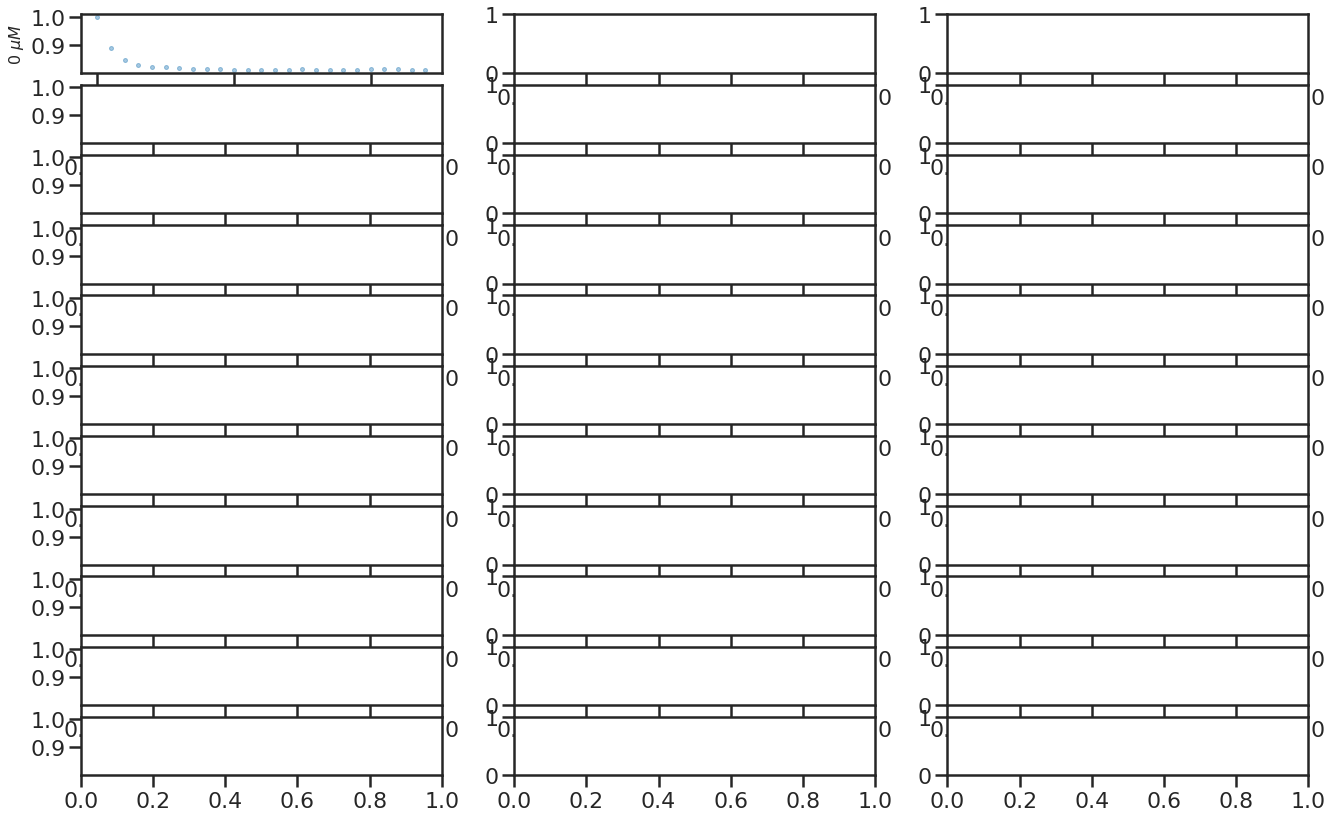

In [55]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
#singExpFitResults={} #store results of fit
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            #fit the intensity values to a decaying exponential
            if col<2:
                #normalize the intensity values
                plotnormarr = plotarr/plotarr.max()
                #fit = singExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, col)].x))
                #singExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Yippee

In [28]:
singExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 5.740625747608287e-05
         x: [ 1.868e-01  2.365e+01  8.124e-01]
       nit: 6
       jac: [-1.108e-06  5.383e-08  5.852e-06]
  hess_inv: [[ 4.976e-01 -4.648e+01 -1.964e-02]
             [-4.648e+01  4.086e+04 -1.109e+01]
             [-1.964e-02 -1.109e+01  2.535e-02]]
      nfev: 60
      njev: 15,
 (np.int64(0),
  0,
  '480'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.702698912799086e-05
         x: [ 1.534e-01  2.500e+01  8.454e-01]
       nit: 2
       jac: [-3.923e-08  9.999e-06  1.644e-08]
  hess_inv: [[ 1.010e+00  2.575e-05 -7.206e-02]
             [ 2.575e-05  1.000e+00 -2.963e-04]
             [-7.206e-02 -2.963e-04  2.514e-02]]
      nfev: 20
      njev: 5,
 (np.int64(30),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.3031877852253627e-05

## Fitting to Double Exponential

In [24]:
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(2) is the weight of the first(second) exponential, tau1(2) is the decay constant of the first(second) exponential
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    

In [28]:
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

In [ ]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


73%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-time

91%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


100%, time elapsed: 2 seconds 

Text(0.5, 0, 'time')

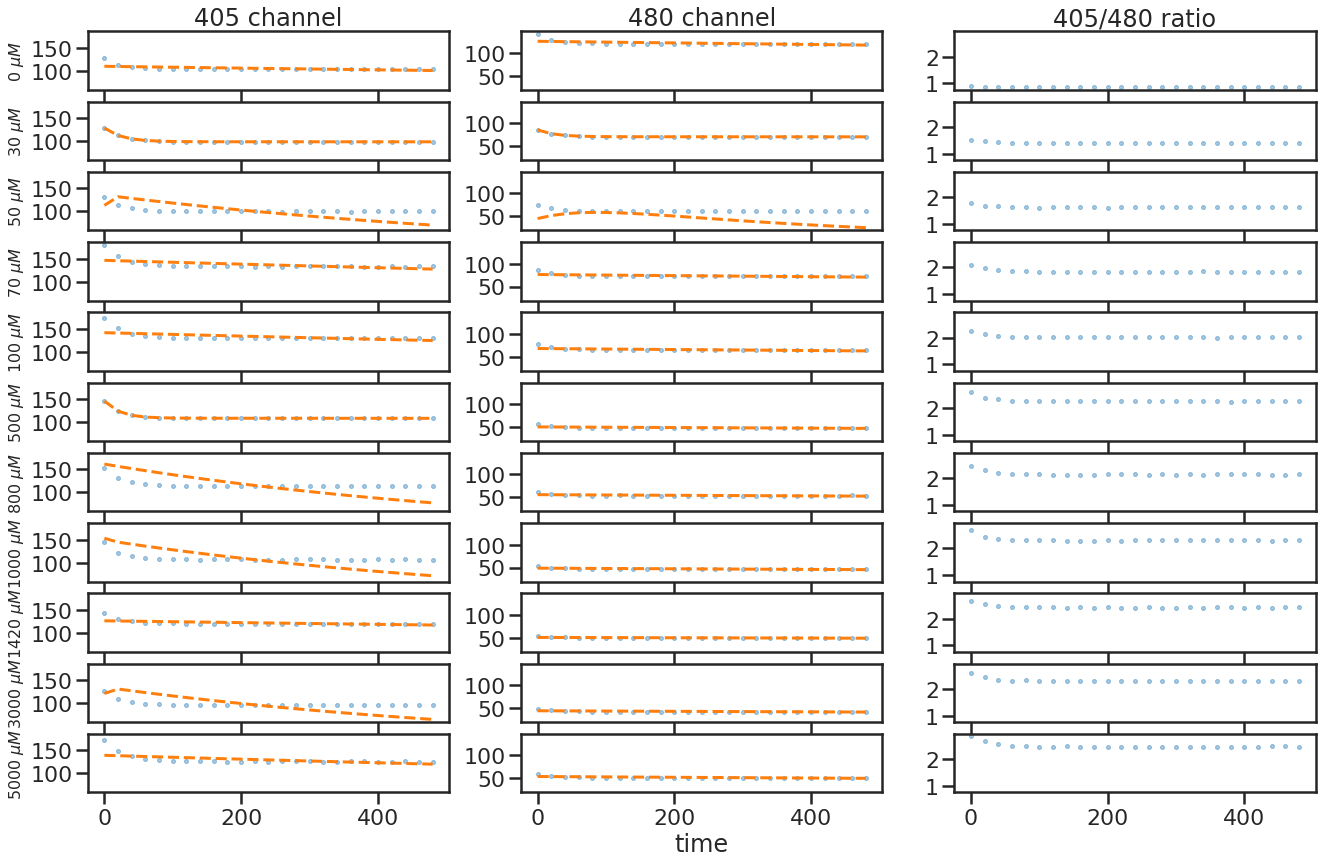

In [59]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time()
doubExpFitResults={}
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(1):
        for col, colname in enumerate(['405', '480', 'ratio']):

            plottimes = np.arange(len(evenedResults[(atp, pos, colname)]))*20 #seconds
            ax[a][col].plot(plottimes, evenedResults[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 

            if col<2:
                fit = doubExpFit(plottimes, evenedResults[(atp, pos, colname)], (10, 50, 15, 300 ))
                ax[a][col].plot(plottimes, doubExp(plottimes, fit.x))
                doubExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [60]:
doubExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 442.40177120377376
         x: [ 2.982e+01  2.985e+03  8.023e+01  7.826e+03]
       nit: 42
       jac: [-2.556e-04  8.240e-04  8.011e-04 -3.357e-04]
  hess_inv: [[ 8.481e+01  1.320e+03 -8.281e+01  3.089e+03]
             [ 1.320e+03  3.459e+04 -1.309e+03  8.258e+04]
             [-8.281e+01 -1.309e+03  8.090e+01 -3.066e+03]
             [ 3.089e+03  8.258e+04 -3.066e+03  1.972e+05]]
      nfev: 434
      njev: 84,
 (np.int64(0),
  0,
  '480'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 377.1621667061019
         x: [-7.300e+01  6.789e+03  1.982e+02  6.950e+03]
       nit: 63
       jac: [ 2.442e-02 -2.289e-05  2.443e-02  1.907e-05]
  hess_inv: [[ 1.268e+03  1.043e+03 -1.260e+03 -4.509e+03]
             [ 1.043e+03  8.577e+02 -1.036e+03 -3.708e+03]
             [-1.260

In [52]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

In [53]:
tempfit.x

array([2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])

In [54]:
temptimes

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480])

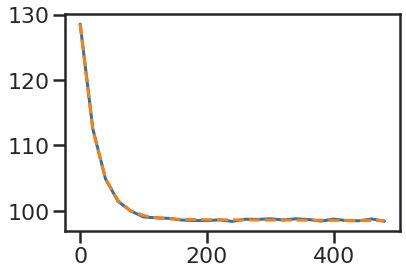

In [58]:
plt.plot(temptimes, evenedResults[(30, 0, '405')])
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05]), ls='--')

## try normalizing

In [81]:
def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential, tau1 is the decay constant of the exponential and Iinf is the limit of the intensity
    """
    w1 = p0[0]
    tau1 = p0[1]
    Iinf = p0[2]

    return w1*np.exp(-times/tau1)+Iinf
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.627362095438604e-05
        x: [ 2.726e-01  2.736e+01  7.277e-01]
      nit: 6
      jac: [ 2.814e-07 -4.743e-09  5.213e-07]
 hess_inv: [[ 4.883e-01 -3.344e+01 -1.850e-02]
            [-3.344e+01  2.080e+04 -8.207e+00]
            [-1.850e-02 -8.207e+00  2.556e-02]]
     nfev: 60
     njev: 15

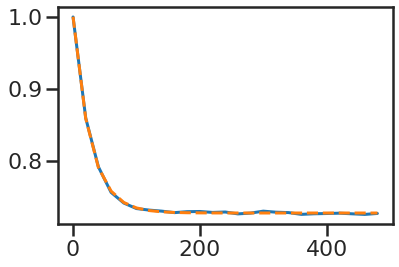

In [83]:
temparr = evenedResults[(5000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = singExpFit(temptimes, tempnormarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, singExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.7523687655807497e-05
        x: [ 2.321e-01  2.549e+01  7.683e-01  2.168e+05]
      nit: 0
      jac: [ 1.061e-08 -4.547e-13  3.284e-07  3.865e-12]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1

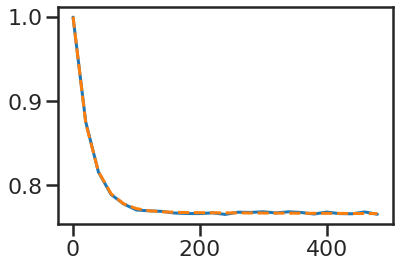

In [72]:
temparr = normedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr/temparr.max(), [2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, temparr/temparr.max())
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.165363217309855e-05
        x: [ 2.368e-01  2.550e+01  7.634e-01  2.000e+05]
      nit: 6
      jac: [ 1.583e-07 -7.562e-10 -7.654e-07  1.501e-11]
 hess_inv: [[ 4.811e-01 -3.601e+01 -1.668e-02  8.002e-05]
            [-3.601e+01  2.527e+04 -8.679e+00 -5.615e-02]
            [-1.668e-02 -8.679e+00  2.467e-02  1.928e-05]
            [ 8.002e-05 -5.615e-02  1.928e-05  1.000e+00]]
     nfev: 75
     njev: 15

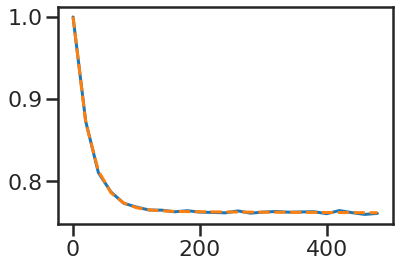

In [75]:
temparr = normedResults[(30, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00039617608998355076
        x: [ 2.416e-01  2.171e+01  7.590e-01  2.000e+05]
      nit: 7
      jac: [ 4.095e-07  1.601e-09  8.959e-07 -2.619e-10]
 hess_inv: [[ 4.861e-01 -2.731e+01 -2.291e-02  1.079e-04]
            [-2.731e+01  1.869e+04 -6.738e+00 -7.387e-02]
            [-2.291e-02 -6.738e+00  2.479e-02  2.663e-05]
            [ 1.079e-04 -7.387e-02  2.663e-05  1.000e+00]]
     nfev: 80
     njev: 16

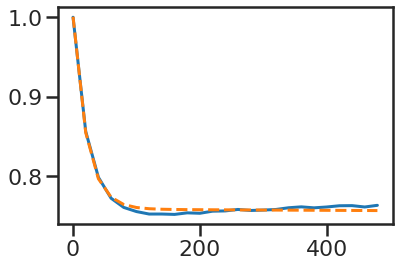

In [80]:
temparr = normedResults[(1000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

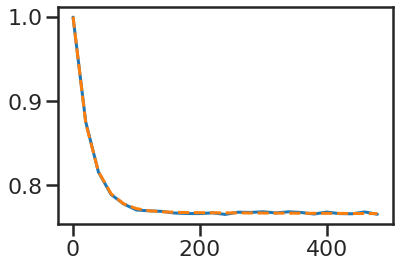

In [71]:
plt.plot(temptimes, normedResults[(30, 0, '405')]/temparr.max())
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])/temparr.max(), ls='--')

In [78]:
ATPconcs

array([   0,   30,   50,   70,  100,  500,  800, 1000, 1420, 3000, 5000])

In [ ]:
def gauss2Dfit(vals, coord):
    residual=lambda pvec: np.sum((vals-evalGauss2Dsimple(coord, pvec))**2)
    initialGuess=(np.median(coord[0]), np.median(coord[1]), np.std(coord[0]), np.percentile(vals, 99))
    print(initialGuess)
    bounds=[(min(coord[0]), max(coord[0])), #limits on muy are the image coordinates subsampled on display!
            (min(coord[1]), max(coord[1])), #limits on mux are ^""
            (0, 5000), #limits on sigma are just positivity
            (0, None)] #limits on I0 are just positivity: GOOD VIBES ONLY
    result=scipy.optimize.minimize(residual, initialGuess, method='L-BFGS-B', options={'gtol':1e-7, 'maxiter':1000})

    return result 

######### the above works for normalization ########


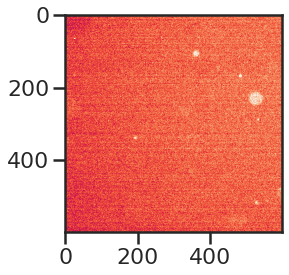

In [191]:
testim = arrs_sub[0][cropAcrossTimes][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

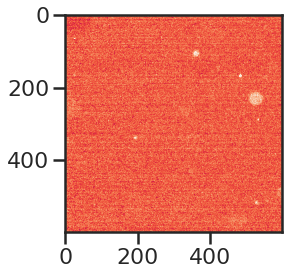

In [190]:
testim = arrs_norm[0][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

In [149]:
mask = np.zeros_like(results[0][0][0])
print(np.sum(mask>0))
mask[cropAcrossTimes] = 1
print(np.sum(mask>0))
allcrop_coords = np.where(mask==1)

0
9000000


In [152]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [151]:
allcrop_coords


(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [168]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1
crop_coords = np.where(mask==1)

mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)


normedResults={}
for atp in ATPconcs[0:1]:
    for pos in range(len(results[atp])):
        arrs = results[atp][pos]
        arrs_sub = backSubtract(arrs, dark_avg)
        arrs_norm=norm_unev(arrs_sub, crop_coords, cropAcrossTimes)
        #ratios = arrs_norm[0][allcrop_coords]/arrs_norm[1][allcrop_coords]

/tmp/ipykernel_440503/3365823086.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


(360000,)


ValueError: operands could not be broadcast together with shapes (25,600,600) (360000,) 

In [174]:
results[0][0][0].shape

(25, 1200, 1920)

In [173]:
results[0][0][0][0].shape

(1200, 1920)

In [166]:
arrs_sub[0][cropAcrossTimes].shape

(25, 600, 600)

In [169]:
len(arrs_sub)

2

In [170]:
arrs_sub[0].shape

(25, 1200, 1920)

In [171]:
arrs_sub[0][crop_coords]

IndexError: index 300 is out of bounds for axis 0 with size 25

In [172]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [161]:
25*600*600

9000000

In [141]:
allcrop_coords[0].shape, crop_coords[0].shape

((9000000,), (360000,))

In [127]:
arrs_sub[1][allcrop_coords]

array([168.        , 144.        , 114.66666667, ..., 106.66666667,
       138.66666667, 117.33333333])